# Credit card fraud detection
Anomaly detection for the dataset Credit card fraud detection using algorithms mentioned below.

- AutoEncoder
- Isolation Forest
- CBLOF
- DBSCAN
- GMM
- Histogram-Based Outlier Detection
- KMeans
- LOF
- OneClassSVM
- PCA

## Imports

In [28]:
! pip install pyod

In [29]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
sns.set()

from sklearn.decomposition import PCA

import tensorflow
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.callbacks import EarlyStopping

# Loading dataset

In [30]:
# Update the file path to the correct location
dataframe = pd.read_csv('/content/drive/MyDrive/Dataset/Numerical/creditcard.csv')
dataframe.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Analysis

In [31]:
for column in dataframe.columns:
    print(f"Value counts for column: {column}")
    print(dataframe[column].value_counts())
    print("\n")

Value counts for column: Time
Time
163152.0    36
64947.0     26
68780.0     25
3767.0      21
3770.0      20
            ..
127750.0     1
62260.0      1
62259.0      1
127753.0     1
172792.0     1
Name: count, Length: 124592, dtype: int64


Value counts for column: V1
V1
 2.055797    77
 1.245674    77
 2.053311    62
 1.302378    60
 2.040211    53
             ..
-0.938907     1
 1.375417     1
-3.762431     1
 1.420284     1
-0.533413     1
Name: count, Length: 275663, dtype: int64


Value counts for column: V2
V2
-0.326668    77
 0.166975    77
 0.089735    62
-0.606529    60
-0.146975    53
             ..
 0.432811     1
-0.504471     1
-1.210369     1
-0.395470     1
-0.189733     1
Name: count, Length: 275663, dtype: int64


Value counts for column: V3
V3
-2.752041    77
 0.488306    77
-1.681836    62
-0.681986    60
-2.955934    53
             ..
 1.268803     1
 0.048443     1
-2.036381     1
 0.377995     1
 0.703337     1
Name: count, Length: 275663, dtype: int64


Val

In [32]:
dataframe.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [33]:
print("Distribuition of Normal(0) and Frauds(1): ")
count_classes = pd.value_counts(dataframe['Class'], sort=True)
count_classes

Distribuition of Normal(0) and Frauds(1): 


Class
0    284315
1       492
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

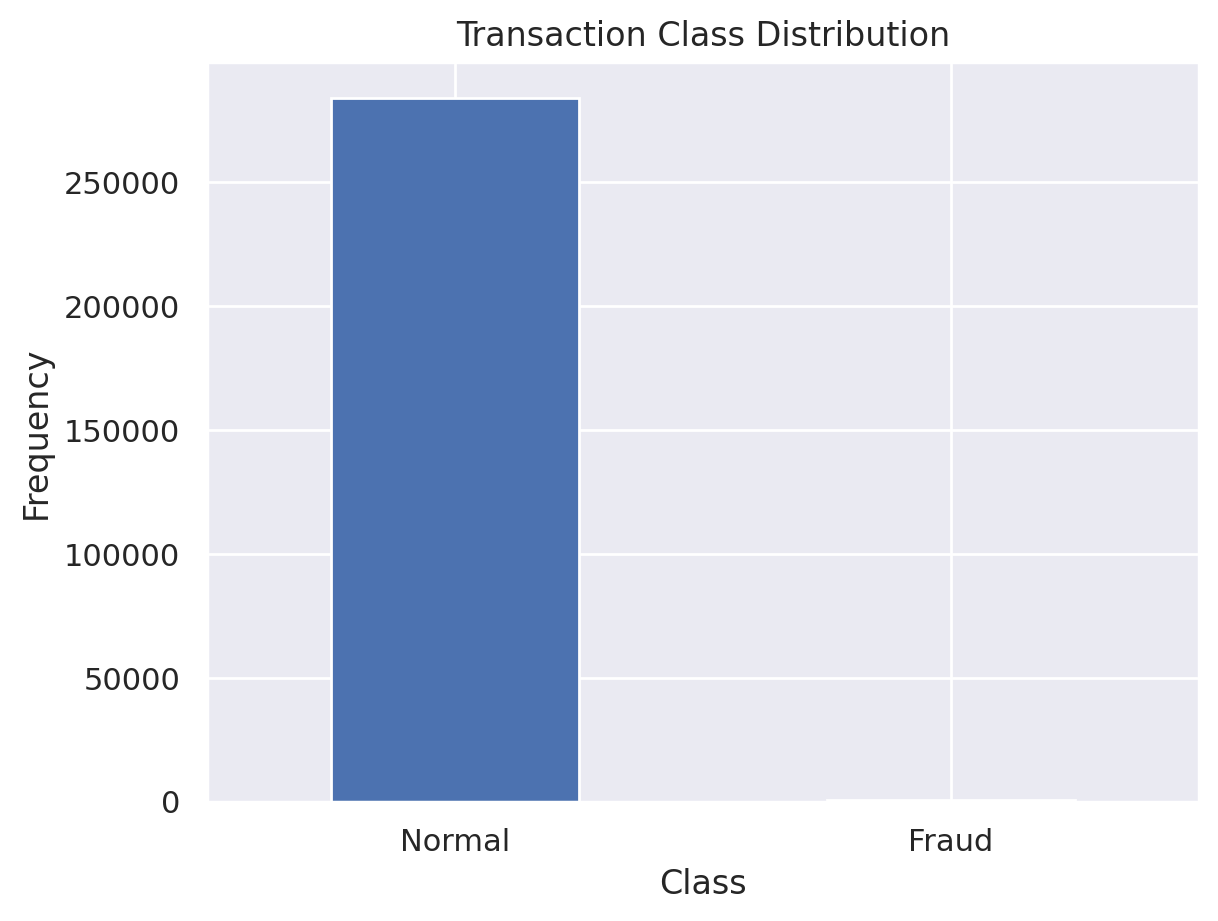

In [34]:
LABELS = ["Normal", "Fraud"]

count_classes.plot(kind="bar", rot=0)
plt.title("Transaction Class Distribution")
# Set labels on x-axis
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

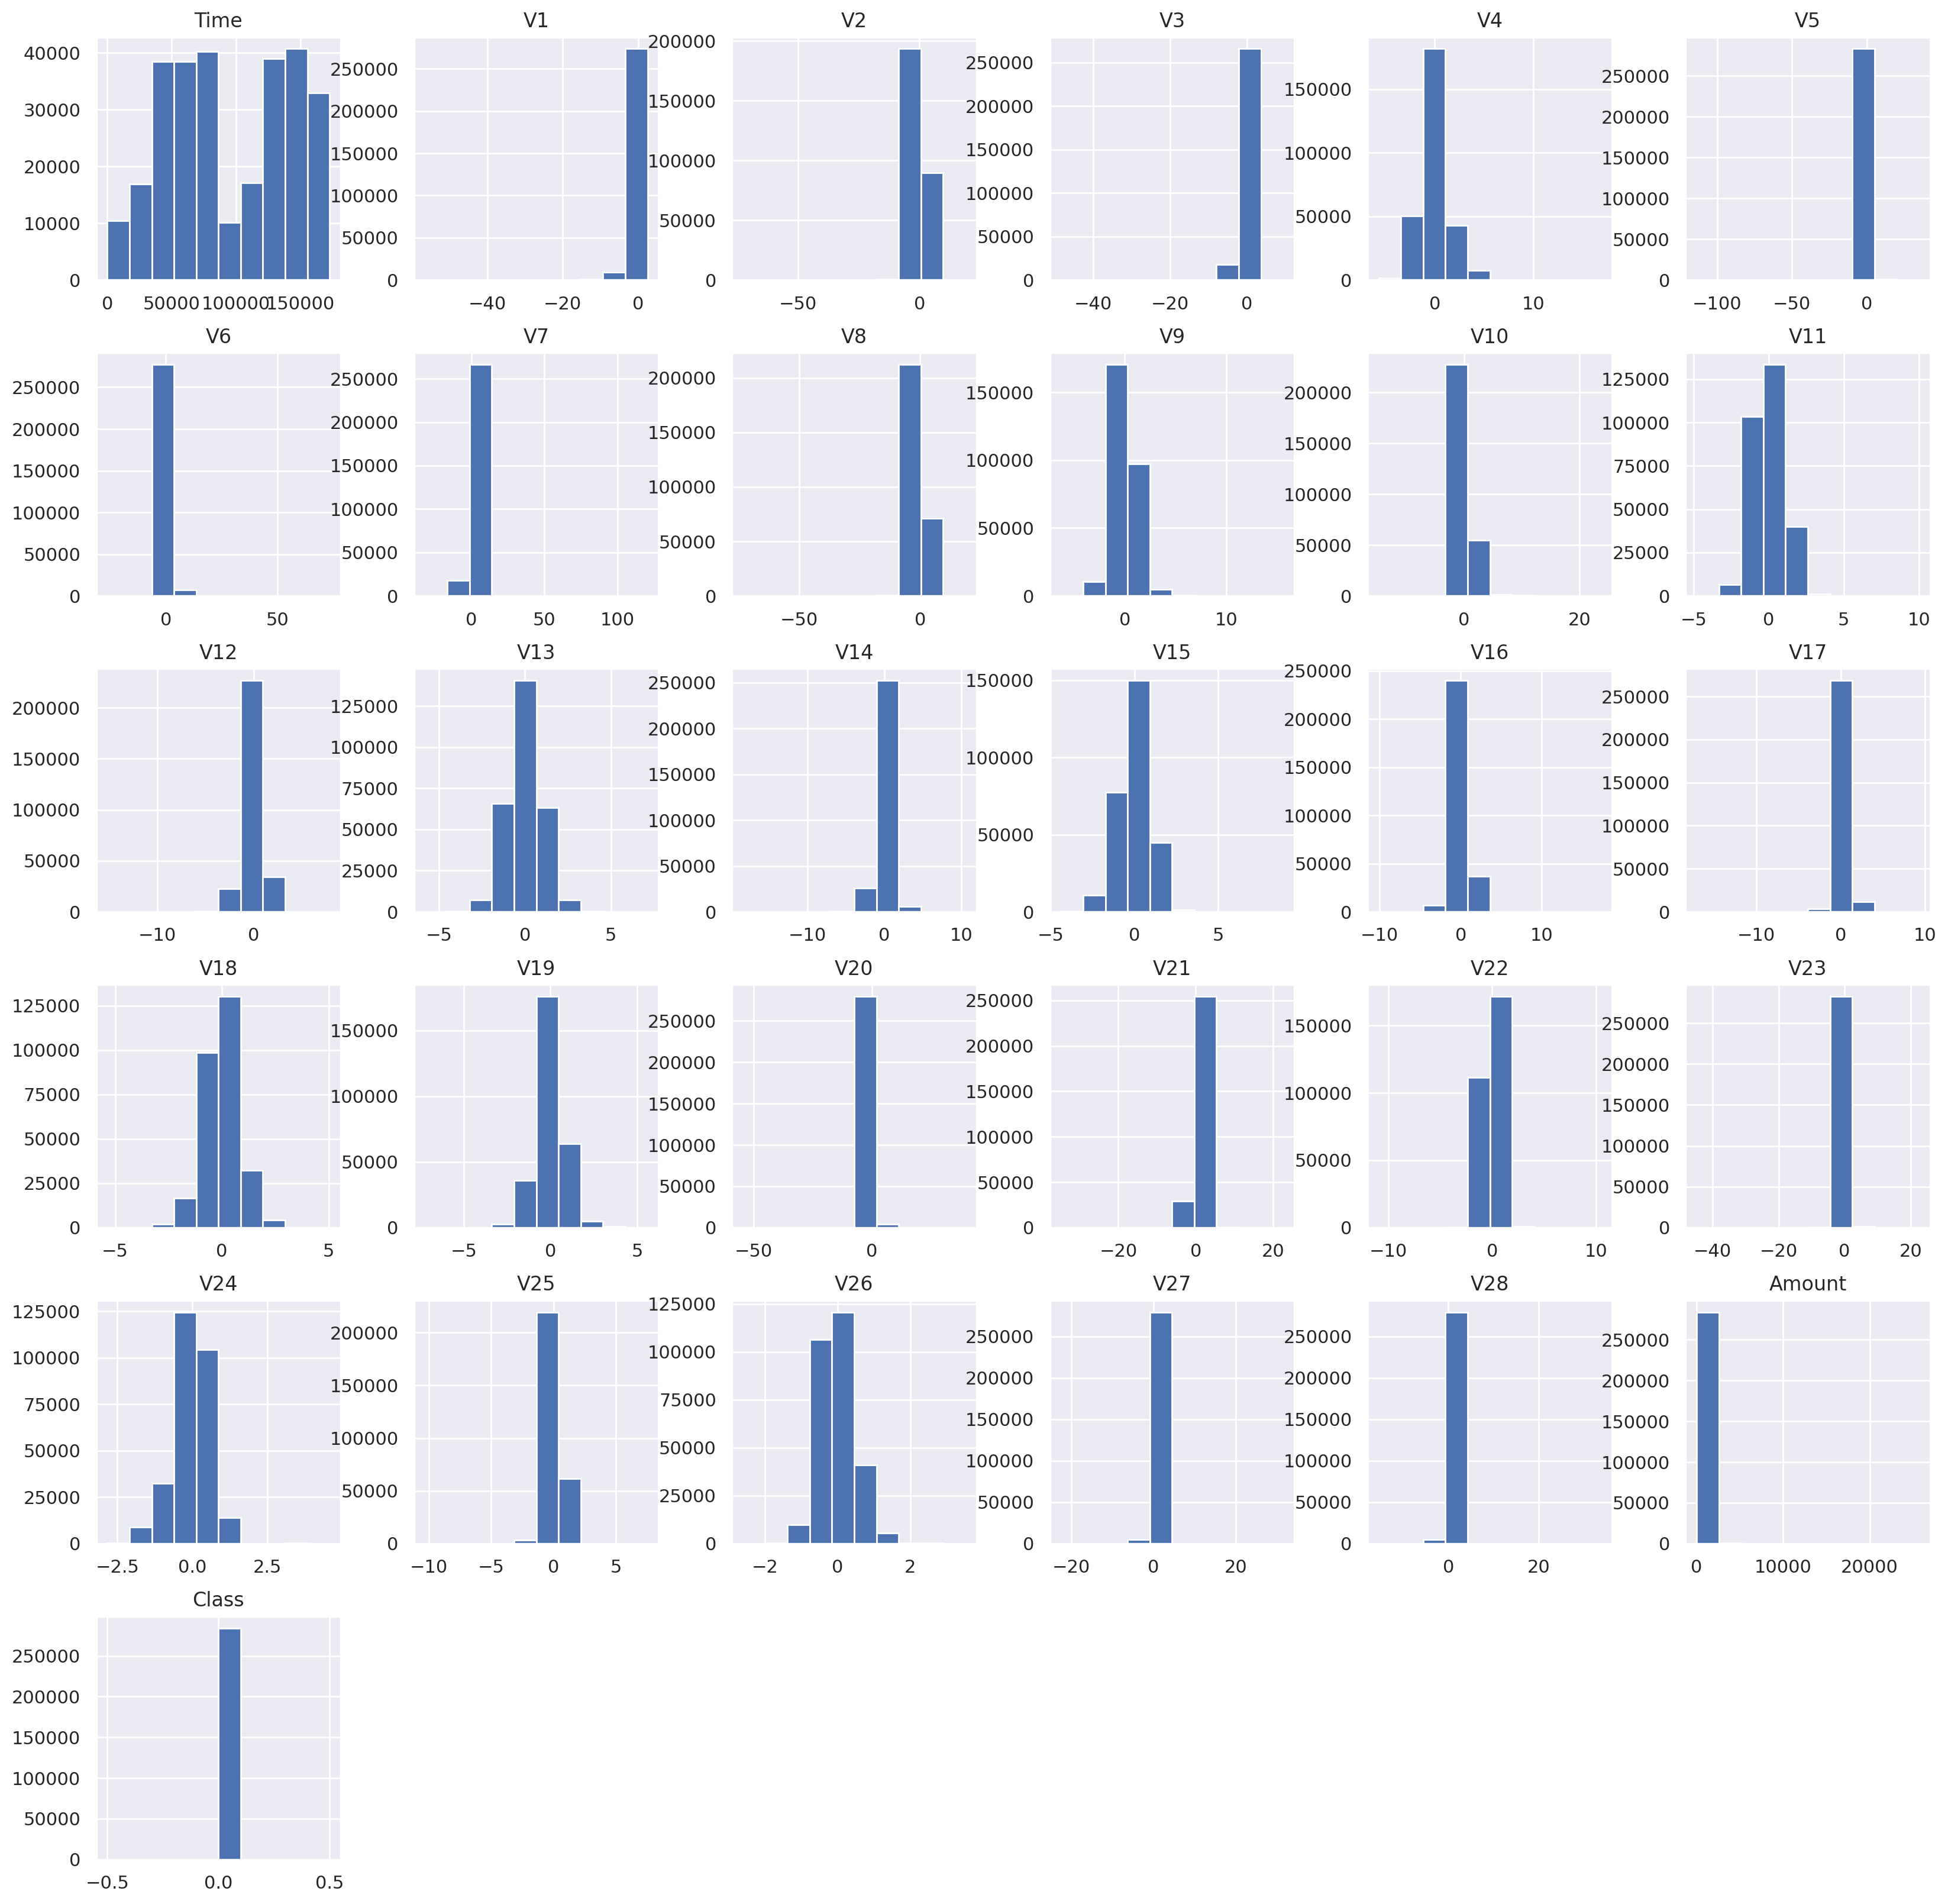

In [35]:
### Normal transaction
dataframe[dataframe.Class == 0].hist(figsize = (20,20))
plt.show()

In [36]:
timedelta = pd.to_timedelta(dataframe['Time'], unit='s')
dataframe['Time_min'] = (timedelta.dt.components.minutes).astype(int)
dataframe['Time_hour'] = (timedelta.dt.components.hours).astype(int)

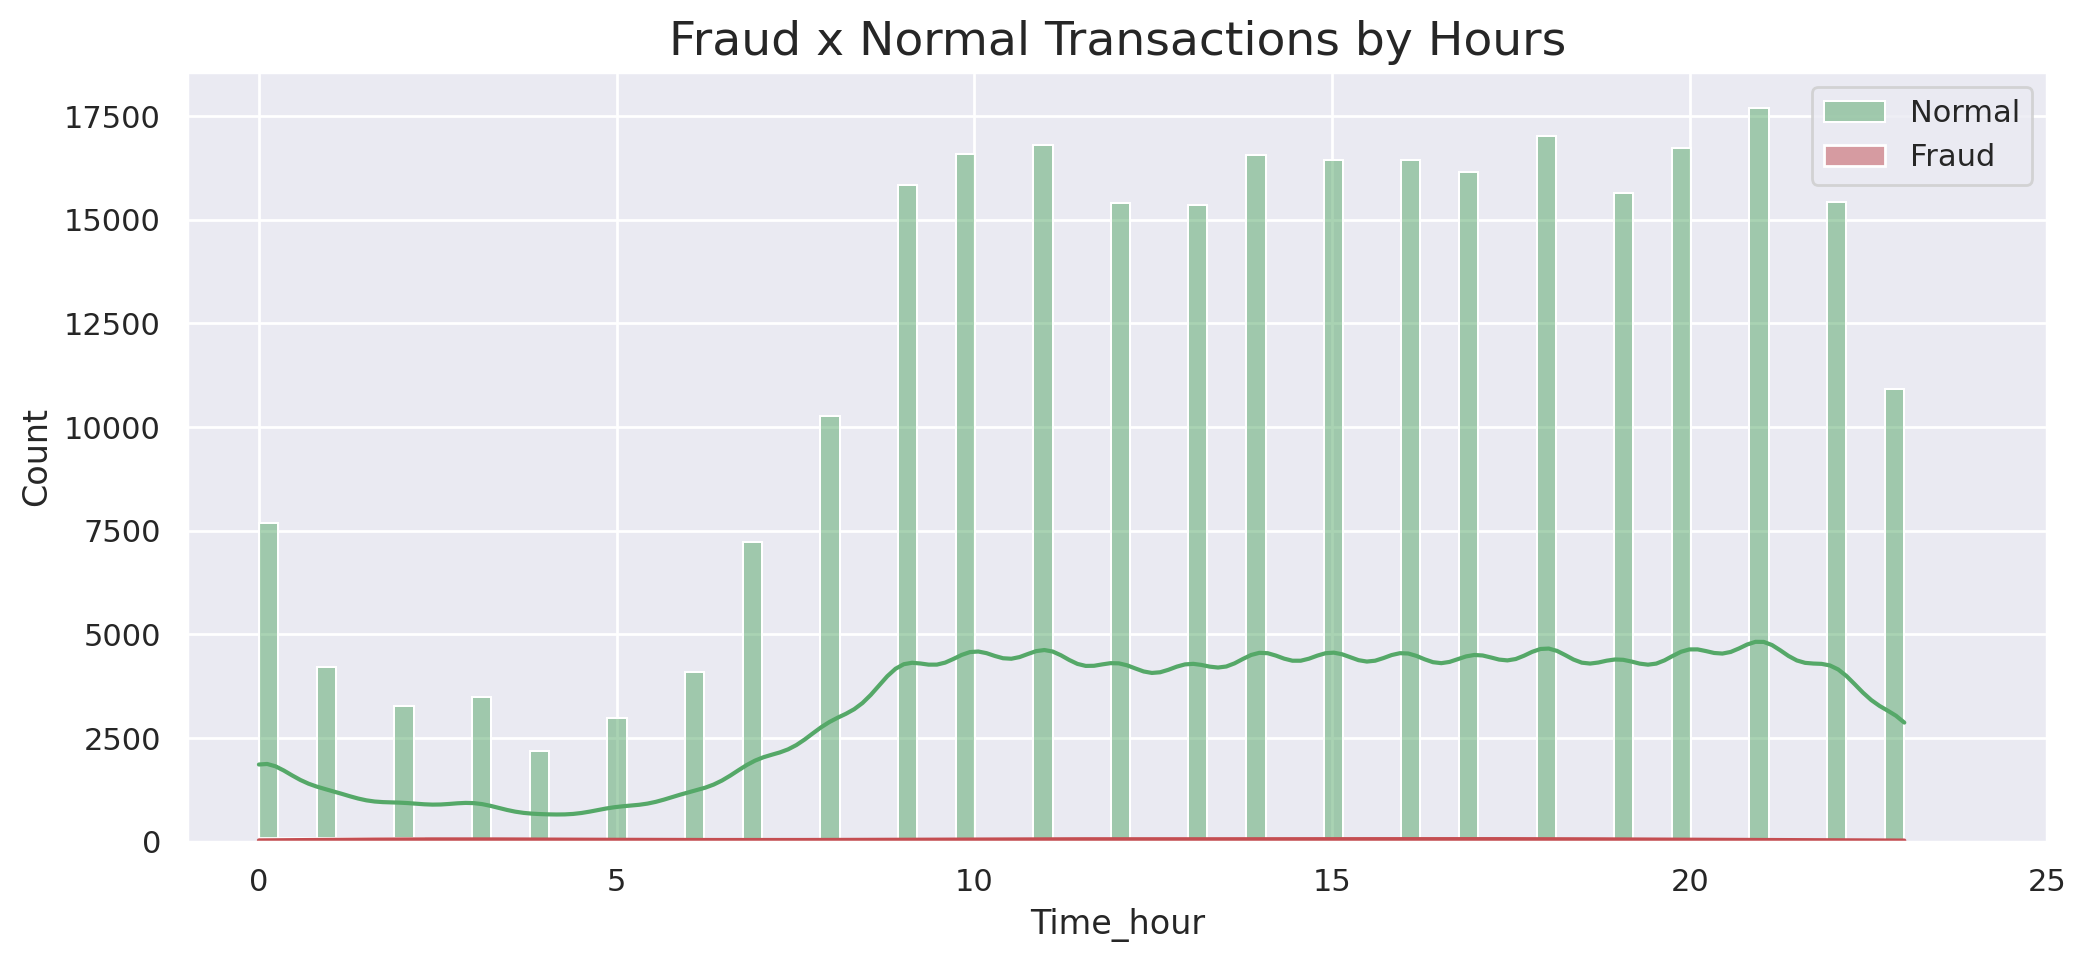

In [37]:
plt.figure(figsize=(12, 5))
sns.histplot(dataframe[dataframe['Class'] == 0]["Time_hour"],  color='g', kde=True, label='Normal')
sns.histplot(dataframe[dataframe['Class'] == 1]["Time_hour"], color='r', kde=True, label='Fraud')
plt.title('Fraud x Normal Transactions by Hours', fontsize=17)
plt.xlim([-1, 25])
plt.legend()
plt.show()

In [38]:
# Remove time in min and hour
dataframe = dataframe.drop(['Time_hour','Time_min'], axis = 1)

In [39]:
dataframe.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [40]:
## separate the Fraud and the Normal dataset for future reference
Fraud = dataframe[dataframe['Class'] == 1]
Normal = dataframe[dataframe['Class'] == 0]

print(Fraud.shape, Normal.shape)

(492, 31) (284315, 31)


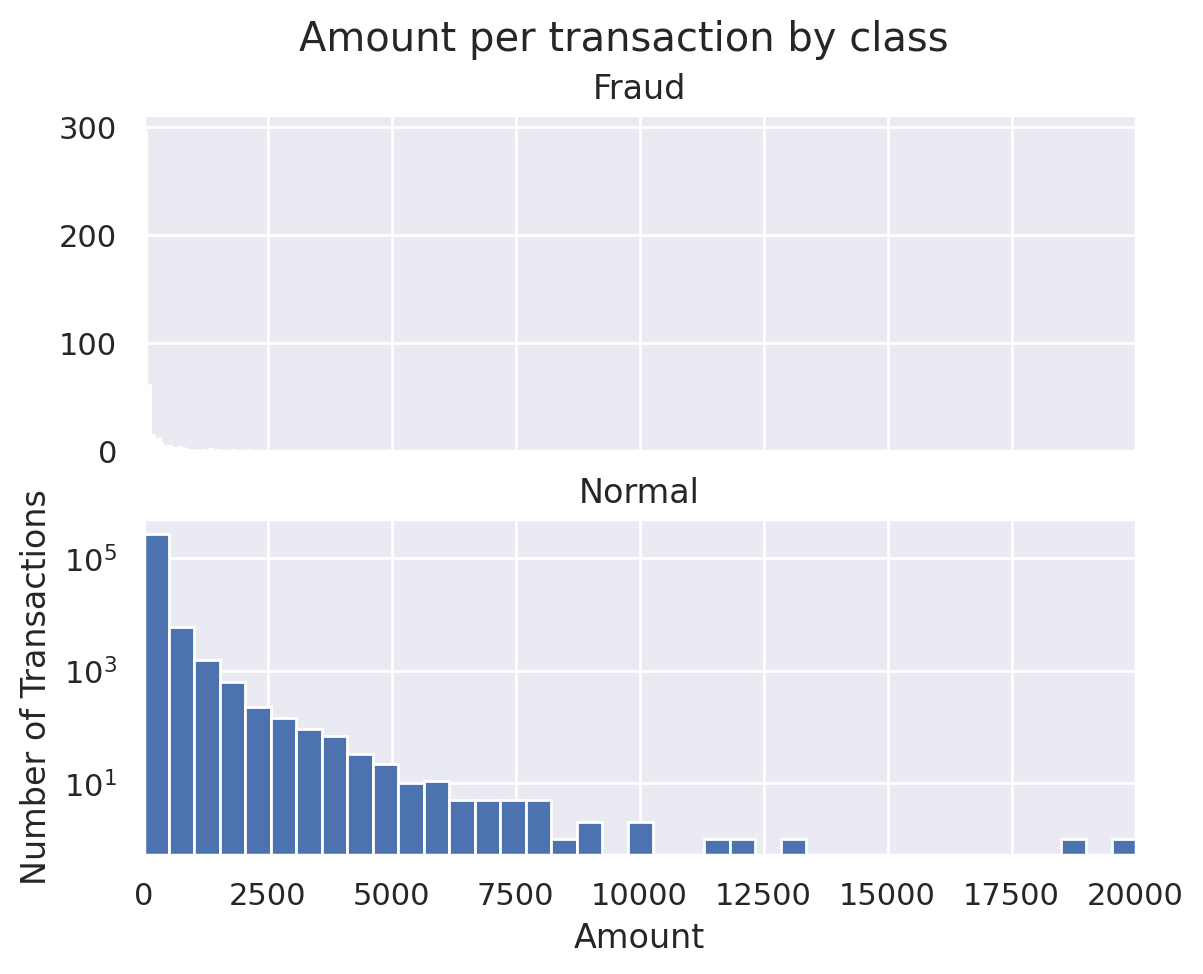

In [41]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
ax1.hist(Fraud.Amount, bins=50)
ax1.set_title('Fraud')
ax2.hist(Normal.Amount, bins=50)
ax2.set_title('Normal')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
# sets the limit of x-axis unit from 0 to 20000
plt.xlim((0, 20000))
# make the y-axis unit in logarithmic scale
plt.yscale('log')
plt.show()

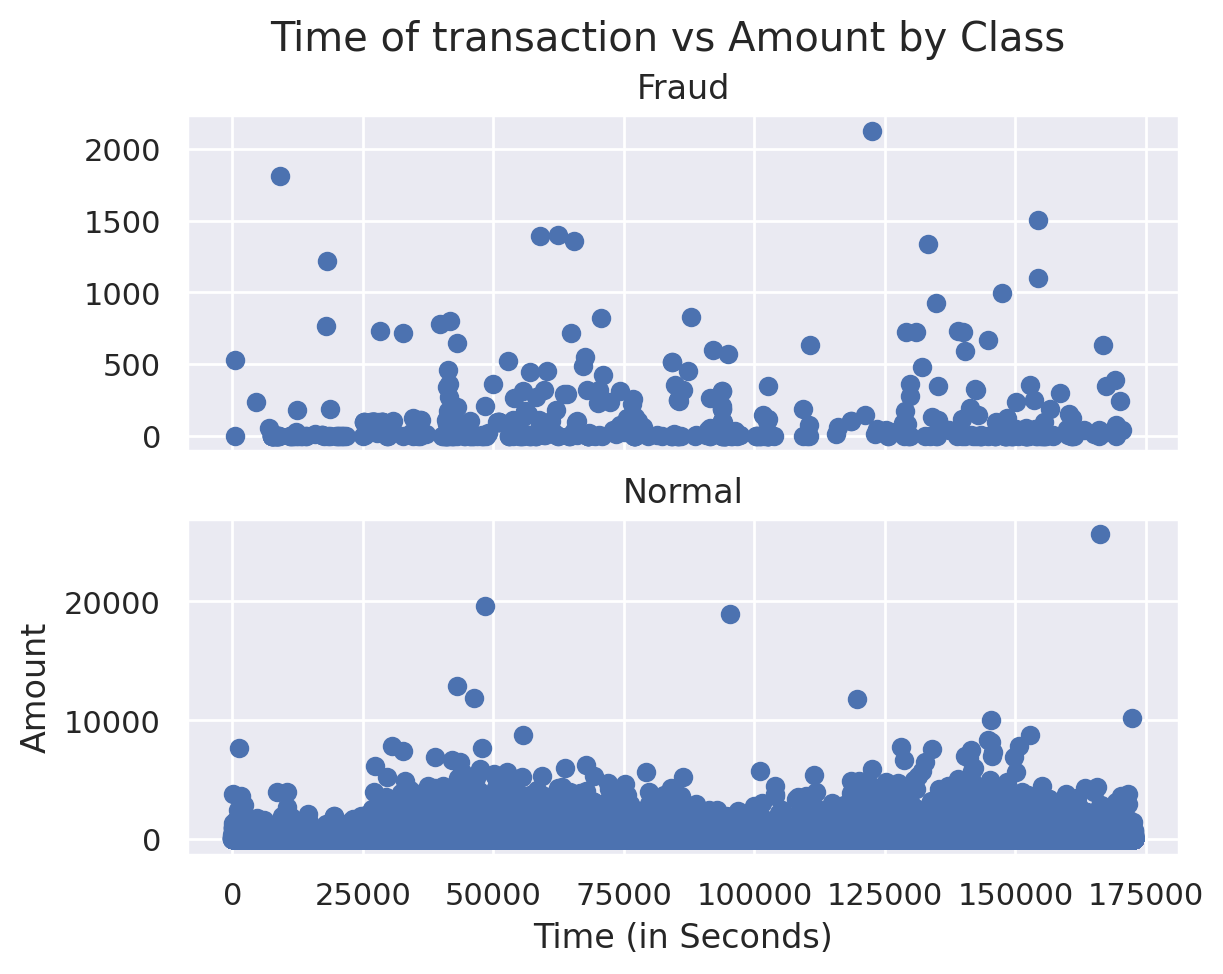

In [42]:
# Create 2 graphs as 2 rows and 1 common column
# between below two graphs share x-axis as common
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle("Time of transaction vs Amount by Class")

# Plot time against amount for fraud transaction
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')

# Plot time against amount for Normal transaction
ax2.scatter(Normal.Time, Normal.Amount)
ax2.set_title('Normal')

# Set X-axis label and y axis label and show the result
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Useful Function

In [43]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [44]:
def fun_label_encode(df, categorical_columns):
    # Create a copy of the original DataFrame
    new_df = df.copy()

    # Convert Categorical features
    label_encoder = LabelEncoder()
    for column in categorical_columns:
        new_df[column] = label_encoder.fit_transform(new_df[column])

    return new_df

In [45]:
## Function to downsample anomaly
def downsample_anomaly(df):
  new_df = df.copy()
  # Count the number of 'Class' 0 and 'Class' 1 instances
  count_class_0 = new_df[new_df['Class'] == 0].shape[0]
  count_class_1 = new_df[new_df['Class'] == 1].shape[0]

  # Calculate the desired count for 'Class' 1 instances
  # I have selected 12% of class normal
  desired_count_class_1 = int(0.12 * count_class_0)

  # Randomly sample the 'Class' 1 instances to match the desired count
  df_class_1_downsampled = new_df[new_df['Class'] == 1].sample(n=desired_count_class_1, random_state=42)

  # Combine the 'Class' 0 instances with the downsampled 'Class' 1 instances
  df_class_0 = new_df[new_df['Class'] == 0]
  df_downsampled = pd.concat([df_class_0, df_class_1_downsampled])

  return df_downsampled

In [46]:
seed = 1337

def get_data(df, clean_train=True):
  """
      clean_train=True returns a train sample that only contains clean samples.
      Otherwise, it will return a subset of each class in train and test (10% outlier)
  """
  clean = df[df.Class == 0].copy().reset_index(drop=True)
  fraud = df[df.Class == 1].copy().reset_index(drop=True)
  print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

  if clean_train:
      train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
      print(f'Train Samples: {len(train)}')

      test = pd.concat([test_clean, fraud]).reset_index(drop=True)

      print(f'Test Samples: {len(test)}')

      # shuffle the test data
      test.sample(frac=1, random_state=seed).reset_index(drop=True)

      train_X, train_y = train.loc[:, ~train.columns.isin(['Class'])], train.loc[:, train.columns.isin(['Class'])]
      test_X, test_y = test.loc[:, ~test.columns.isin(['Class'])], test.loc[:, test.columns.isin(['Class'])]
  else:
      clean_train, clean_test = train_test_split(clean, test_size=int(len(fraud)+(len(fraud)*0.9)), random_state=seed)
      fraud_train, fraud_test = train_test_split(fraud, test_size=int(len(fraud)*0.1), random_state=seed)

      train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
      test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)

      # shuffle
      train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)

      print(f'Train Samples: {len(train_samples)}')
      test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)

      print(f'Test Samples: {len(test_samples)}')
      train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['Class'])], train_samples.loc[:, train_samples.columns.isin(['Class'])]
      test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['Class'])], test_samples.loc[:, test_samples.columns.isin(['Class'])]

  return train_X, train_y, test_X, test_y

In [47]:
def get_confusion_matrix(test_y, test_yhat):
  cm = confusion_matrix(test_y, test_yhat)

  fig, ax = plt.subplots(1, 1,figsize=(10,10))

  tick_labels = ['Normal','Fraudulent']

  # calculate output
  total = np.sum(cm)

  # Actually True
  tp = cm[0][0]
  fn = cm[0][1]

  # Actually false
  fp = cm[1][0]
  tn = cm[1][1]

  tp_o = np.round((tp / total)*100,3)
  fn_o = np.round((fn / total)*100,3)
  fp_o = np.round((fp / total)*100,3)
  tn_o = np.round((tn / total)*100,3)

  tp_c = np.round(max((tp / (tp + fn)), 0.0)*100,3)
  fn_c = np.round(max((fn / (tp + fn)), 0.0)*100,3)
  fp_c = np.round(max((fp / (fp + tn)), 0.0)*100,3)
  tn_c = np.round(max((tn / (fp + tn)), 0.0)*100,3)

  labels = np.array([
      [f'TP\nCount: {tp}\nOverall: {tp_o}%\nTPR: {tp_c}%',
       f'FN (Type 2)\nCount: {fn}\nOverall: {fn_o}%\nFNR: {fn_c}%'],
      [f'FP (Type 1)\nCount: {fp}\nOverall: {fp_o}%\nFPR: {fp_c}%',
       f'TN\nCount: {tn}\nOverall: {tn_o}%\nTNR: {tn_c}%']
      ])

  sns.heatmap(cm, ax=ax, annot=labels, fmt='', cmap=plt.cm.RdYlBu)

  ax.set_title('Confusion Matrix', fontsize=14)

  ax.set_xticklabels(tick_labels, fontsize=14, rotation=0)
  ax.set_xlabel('Predicted', fontsize=20)
  ax.set_yticklabels(tick_labels, fontsize=14, rotation=0)
  ax.set_ylabel('Actual', fontsize=20)

  plt.show()

# Auto Encoder

In [50]:
df = dataframe.copy()

The columns listed below seems irrelevant

In [51]:
df_selected = df.drop(['V15','V17','V24','V27','Time'], axis = 1)

In [52]:
df_selected.shape

(284807, 26)

In [53]:
df_training, df_testing = train_test_split(df_selected,test_size = 0.2, random_state = 42,stratify = df_selected.Class)

In [54]:
df_testing.Class.value_counts()

Class
0    56864
1       98
Name: count, dtype: int64

In [55]:
train_data,validation_data,train_lable, validation_lable = train_test_split(df_training.loc[:,df_training.columns != 'Class'],df_training.Class,test_size = 0.2, stratify  = df_training.Class, random_state = 42)

In [56]:
##### here we are going to use min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit(train_data)
train_data_normalised = data_scaled.transform(train_data)
validation_data_normalised = data_scaled.transform(validation_data)

test_data = df_testing.loc[:, df_testing.columns != 'Class']
test_lable = df_testing.Class
test_data_normalised = data_scaled.transform(test_data)

In [57]:
print(f"train_data_normalised.shape: {train_data_normalised.shape}")
print(f"validation_data_normalised.shape: {validation_data_normalised.shape}")
print(f"test_data_normalised.shape: {test_data_normalised.shape}")

train_data_normalised.shape: (182276, 25)
validation_data_normalised.shape: (45569, 25)
test_data_normalised.shape: (56962, 25)


In [58]:
# lets change the labels with boolean
train_lable,validation_lable, test_lable = train_lable.astype(bool), validation_lable.astype(bool), test_lable.astype(bool)

In [59]:
# now  lets seperate the normal and fraud data out of training dataset
normal_train_data = train_data_normalised[~train_lable] # normal transactions out of train_data_normalised
normal_test_data = test_data_normalised[~test_lable] # normal transactions out of test_data_normalised
normal_validation_data = validation_data_normalised[~validation_lable]

In [60]:
print(len(normal_train_data))
print(len(normal_test_data))
print(len(normal_validation_data))

181961
56864
45490


In [61]:
fraud_train_data = train_data_normalised[train_lable]
fraud_test_data = test_data_normalised[test_lable]
fraud_validation_data = validation_data_normalised[validation_lable]

In [62]:
print(len(fraud_train_data))
print(len(fraud_test_data))
print(len(fraud_validation_data))

315
98
79


**Normal Data**

In [63]:
normal_train_data[0].shape

(25,)

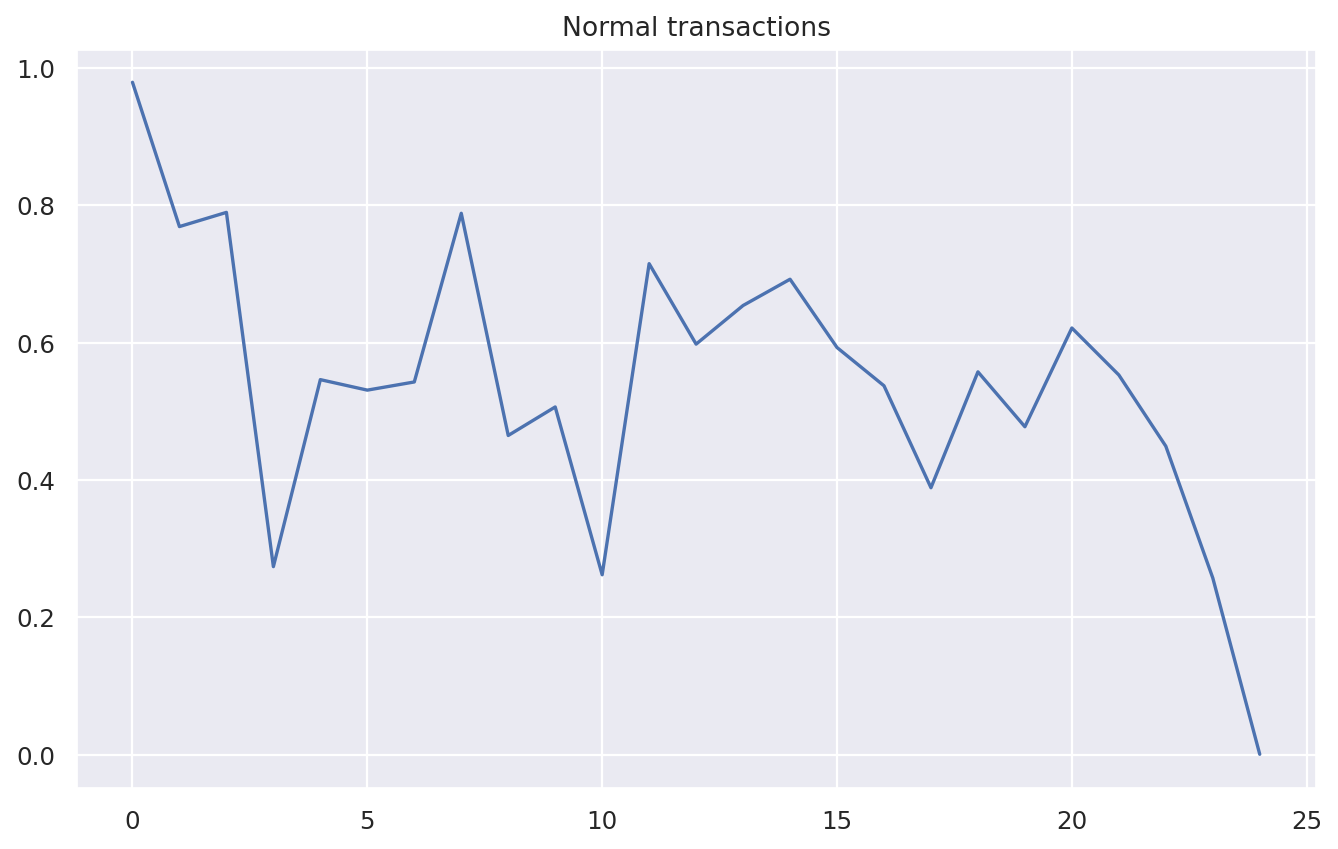

In [64]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)
plt.plot(np.arange(25), normal_train_data[1])
plt.title('Normal transactions')

plt.show()

**Fraud Data**

In [65]:
fraud_train_data[2]

array([0.86313861, 0.82236022, 0.60757087, 0.61178208, 0.51190726,
       0.5049505 , 0.46397614, 0.82124406, 0.30748151, 0.35697646,
       0.71079904, 0.29589388, 0.80944407, 0.30165222, 0.41927119,
       0.5202625 , 0.71738895, 0.39369728, 0.58151548, 0.53001624,
       0.61770724, 0.52496163, 0.50082531, 0.24652224, 0.        ])

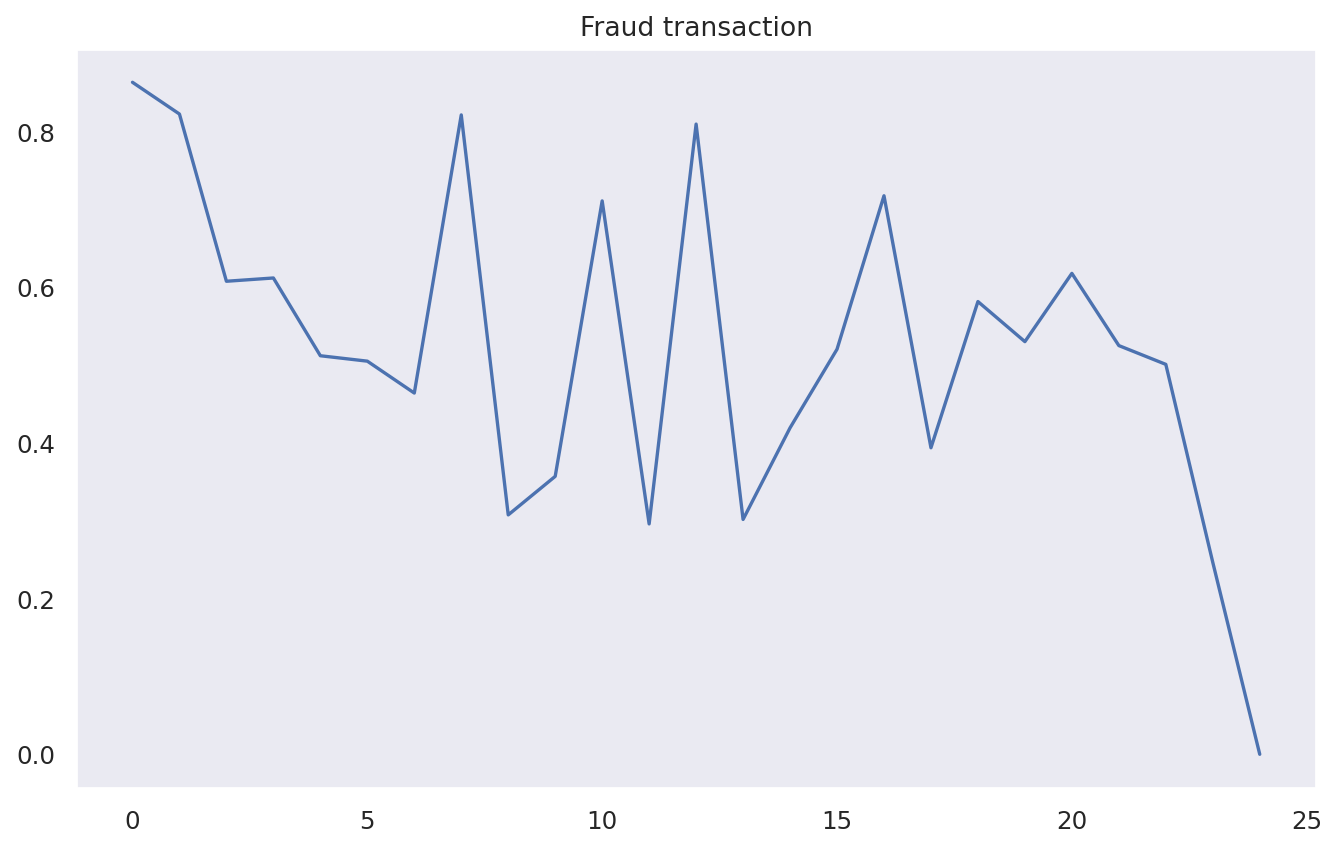

In [66]:
#Lets plot one from fraud transaction
figure(figsize=(10, 6), dpi=80)

plt.plot(np.arange(25), fraud_train_data[2])
plt.grid()
plt.title('Fraud transaction')
plt.show()

**Encoder Design**

In [67]:
n_features = len(train_data.columns)
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=200, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=100, activation=activations.relu))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))

**Decoder Design**

In [68]:
decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=100, activation=activations.relu, input_shape=[5]))
decoder.add(layer=layers.Dense(units=200, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

In [69]:
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss=losses.MSE, optimizer=optimizers.Adam(), metrics=[metrics.mean_squared_error])

In [70]:
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,restore_best_weights=True)
history = autoencoder.fit(x=normal_train_data, y=normal_train_data, epochs=100, verbose=1, validation_data=(normal_validation_data, normal_validation_data), callbacks=[es])

Epoch 1/100
5687/5687 [==============================] - 16s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.0036e-04 - val_mean_squared_error: 7.0036e-04
Epoch 2/100
5687/5687 [==============================] - 14s 3ms/step - loss: 6.9563e-04 - mean_squared_error: 6.9563e-04 - val_loss: 6.3658e-04 - val_mean_squared_error: 6.3658e-04
Epoch 3/100
5687/5687 [==============================] - 14s 3ms/step - loss: 6.2752e-04 - mean_squared_error: 6.2752e-04 - val_loss: 5.7129e-04 - val_mean_squared_error: 5.7129e-04
Epoch 4/100
5687/5687 [==============================] - 14s 3ms/step - loss: 5.3925e-04 - mean_squared_error: 5.3925e-04 - val_loss: 4.5236e-04 - val_mean_squared_error: 4.5236e-04
Epoch 5/100
5687/5687 [==============================] - 14s 2ms/step - loss: 4.8038e-04 - mean_squared_error: 4.8038e-04 - val_loss: 4.2049e-04 - val_mean_squared_error: 4.2049e-04
Epoch 6/100
5687/5687 [==============================] - 14s 3ms/step - loss: 4.5796e-04 - mean_sq

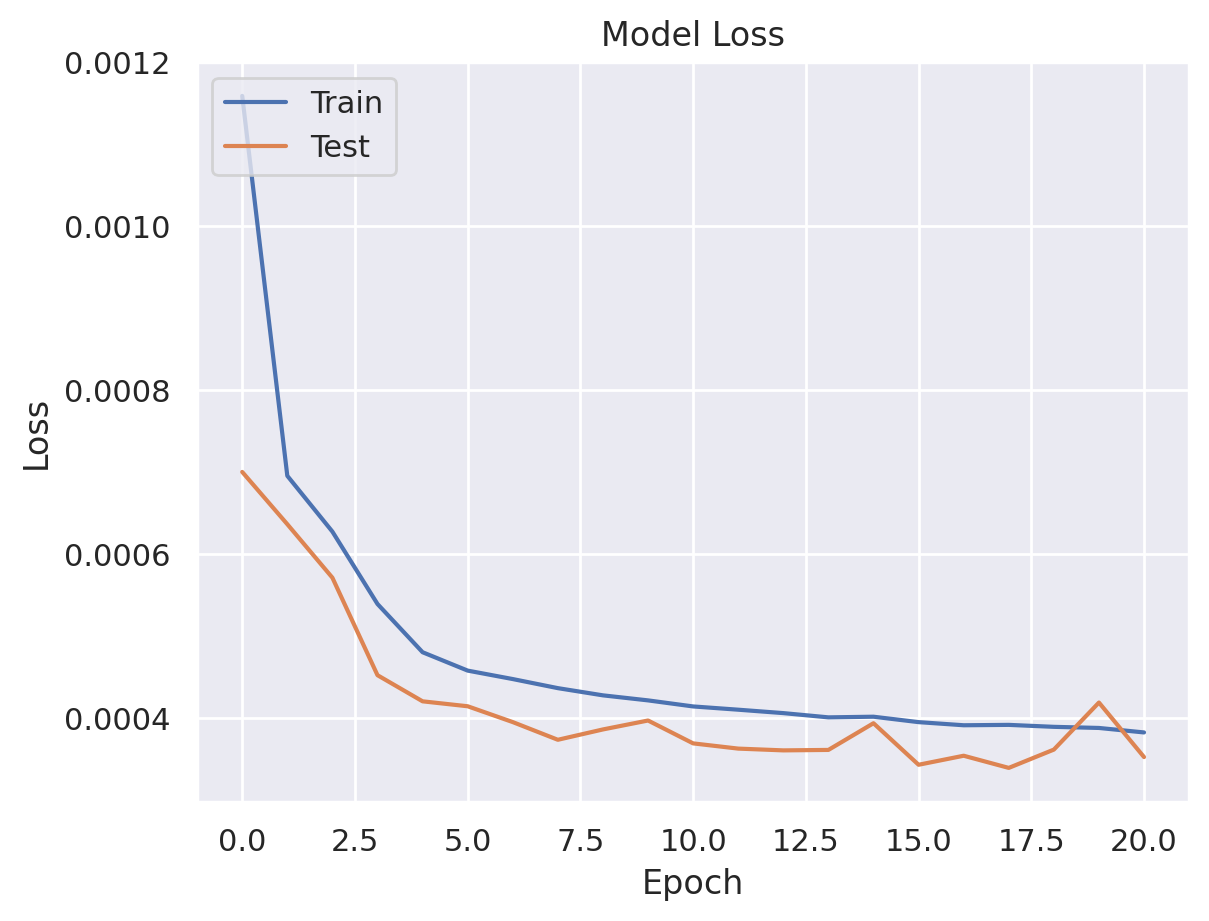

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [72]:
# Define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  dec_img = autoencoder.predict(data) # this will decode or reconstruct
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(25), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

1777/1777 [==============================] - 2s 1ms/step


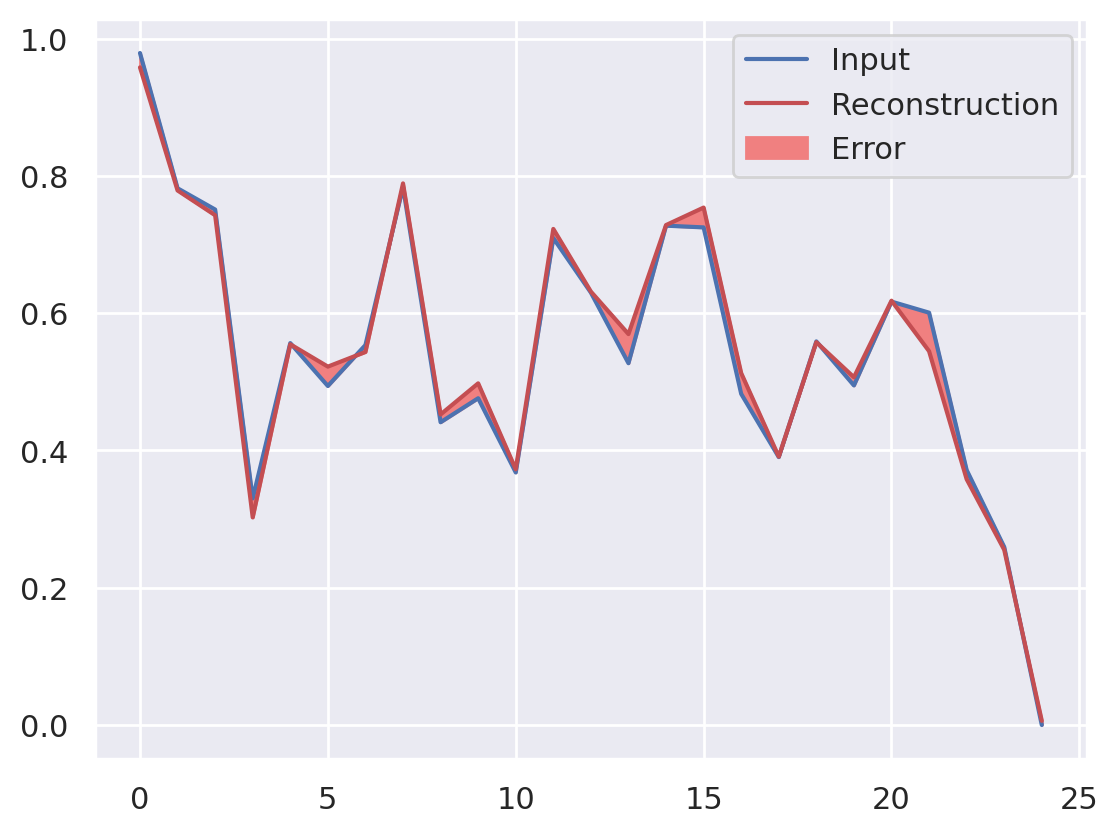

4/4 [==============================] - 0s 2ms/step


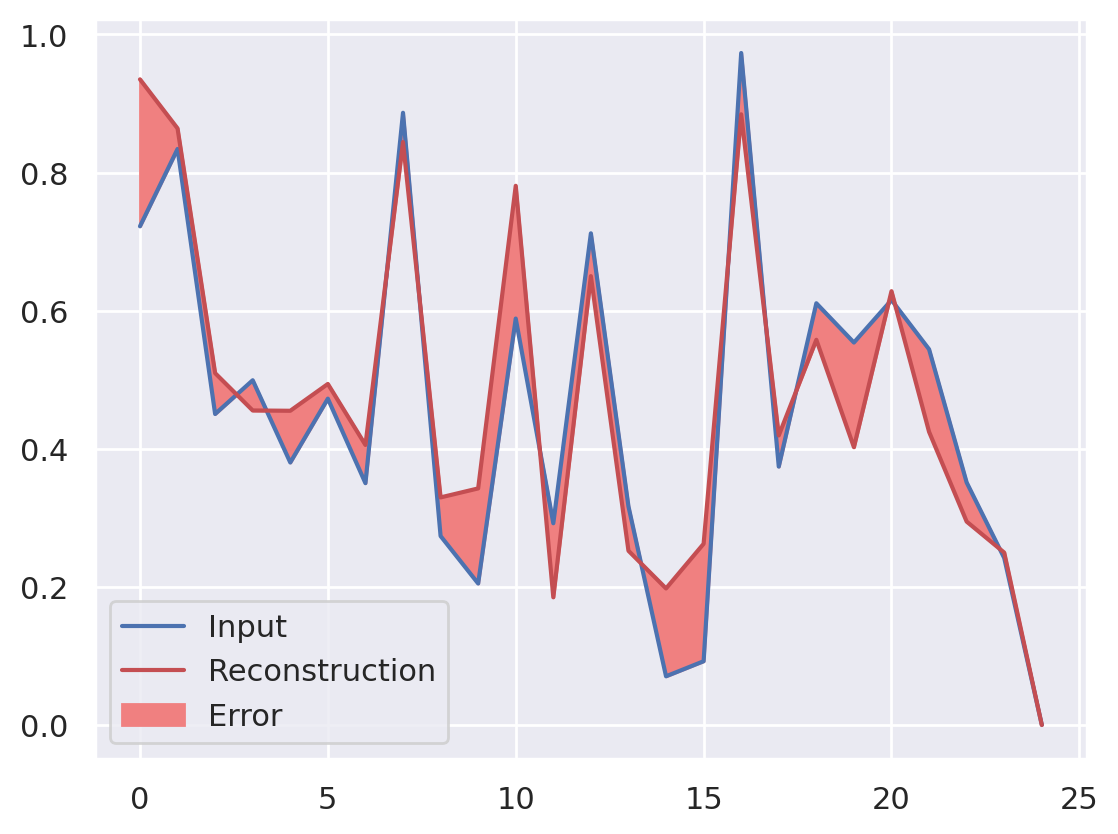

In [73]:
plot(normal_test_data, 4) # here n shows the index of ecg samples
plot(fraud_test_data, 4)

10/10 [==============================] - 0s 1ms/step
0.058413965650311074


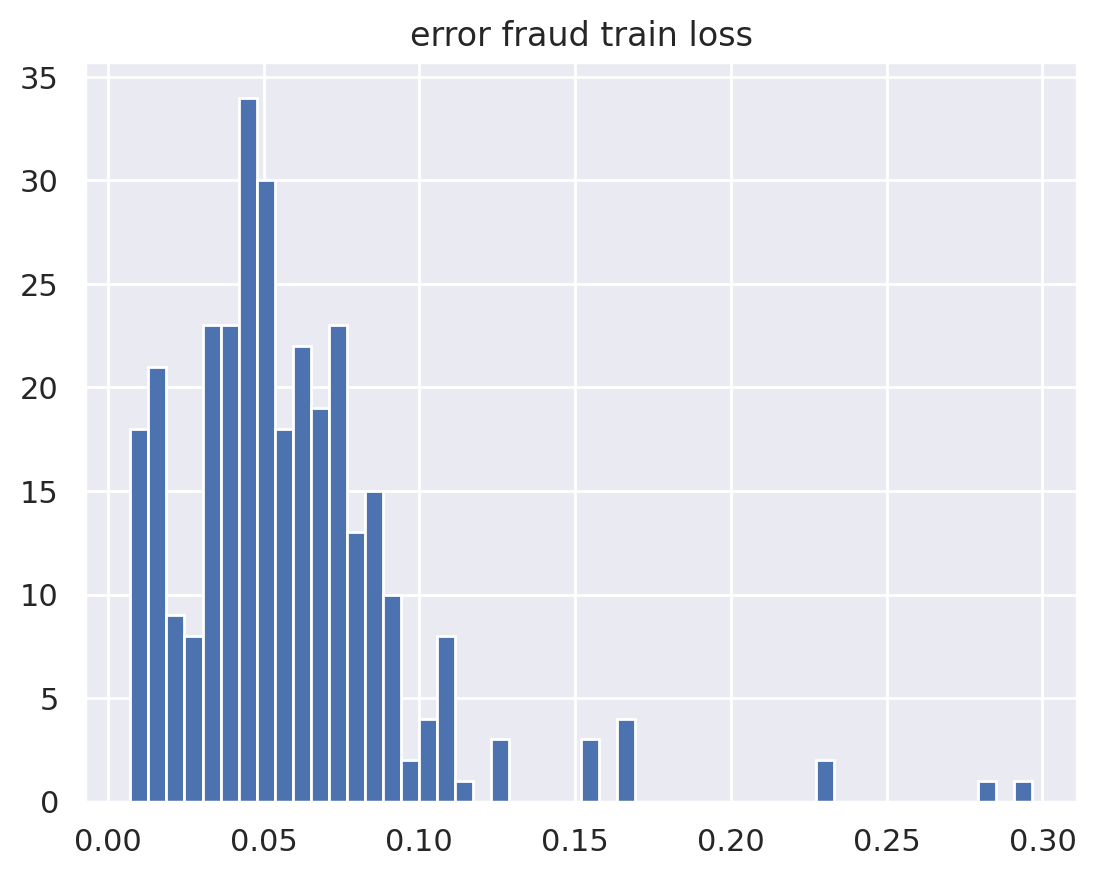

In [74]:
### calculating the train error  in fraud transactions
reconstructed = autoencoder.predict(fraud_train_data)
train_fraud_loss = losses.mae(reconstructed, fraud_train_data).numpy()
print(np.mean(train_fraud_loss))
plt.hist(train_fraud_loss, bins = 50)
plt.title('error fraud train loss')
plt.show()


In [75]:
Fraud = df.Class.sum()
total = len(df)
fraud_percentage = (Fraud/total)*100
fraud_percentage
# so lets say that 1% of transactions are fraud so lets find the threshold

0.1727485630620034

In [76]:
# calcualting the error in the whole train data
reconstructed = autoencoder.predict(train_data_normalised)
train_loss = losses.mae(reconstructed, train_data_normalised).numpy()

5697/5697 [==============================] - 7s 1ms/step


There are two ways to set our threshold
1. set up by using percentile (suppose we have 2% of fraud transaction so our aim will be filter 2% probable data)
2. set up by using distribution and try to find the outliers

In [77]:
# we are assuming that we have 1% of fraud transaction here
cut_off_1 = np.percentile(train_loss, 99.7)
cut_off_1

0.050834054721254525

In [78]:
cut_off_2 = np.mean(train_loss) + 5*np.std(train_loss)
cut_off_2
# 2std division covers 97% of the distribution and here i have taken 3 std division

0.04485881913904172

if error is greater than this value we would say fraud transaction if lesser than cut-off means legitimate transaction

Prediction on our TEST data

In [79]:
reconstructed = autoencoder.predict(test_data_normalised)
errors = losses.mae(reconstructed,test_data_normalised)
len(errors)
predicted = []
for error in errors:
    if error > cut_off_1:
        predicted.append(1)
    else:
        predicted.append(0)

1781/1781 [==============================] - 2s 1ms/step


In [80]:
np.sort(errors)[::-1]

array([0.16731139, 0.16446483, 0.16446483, ..., 0.00229956, 0.00225985,
       0.00221656])

In [81]:
predicted_fraud_cases = np.array(predicted).sum()
actual_fraud_cases = test_lable.sum()
print('predicted_fruad_cases =>'.format(), predicted_fraud_cases, 'true fraud cases =>'.format(), actual_fraud_cases)

predicted_fruad_cases => 187 true fraud cases => 98


In [82]:
# From booliean Map back to 1 and 0
true_lable = test_lable.map({True:1,False:0})

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.32      0.60      0.41        98

    accuracy                           1.00     56962
   macro avg       0.66      0.80      0.71     56962
weighted avg       1.00      1.00      1.00     56962



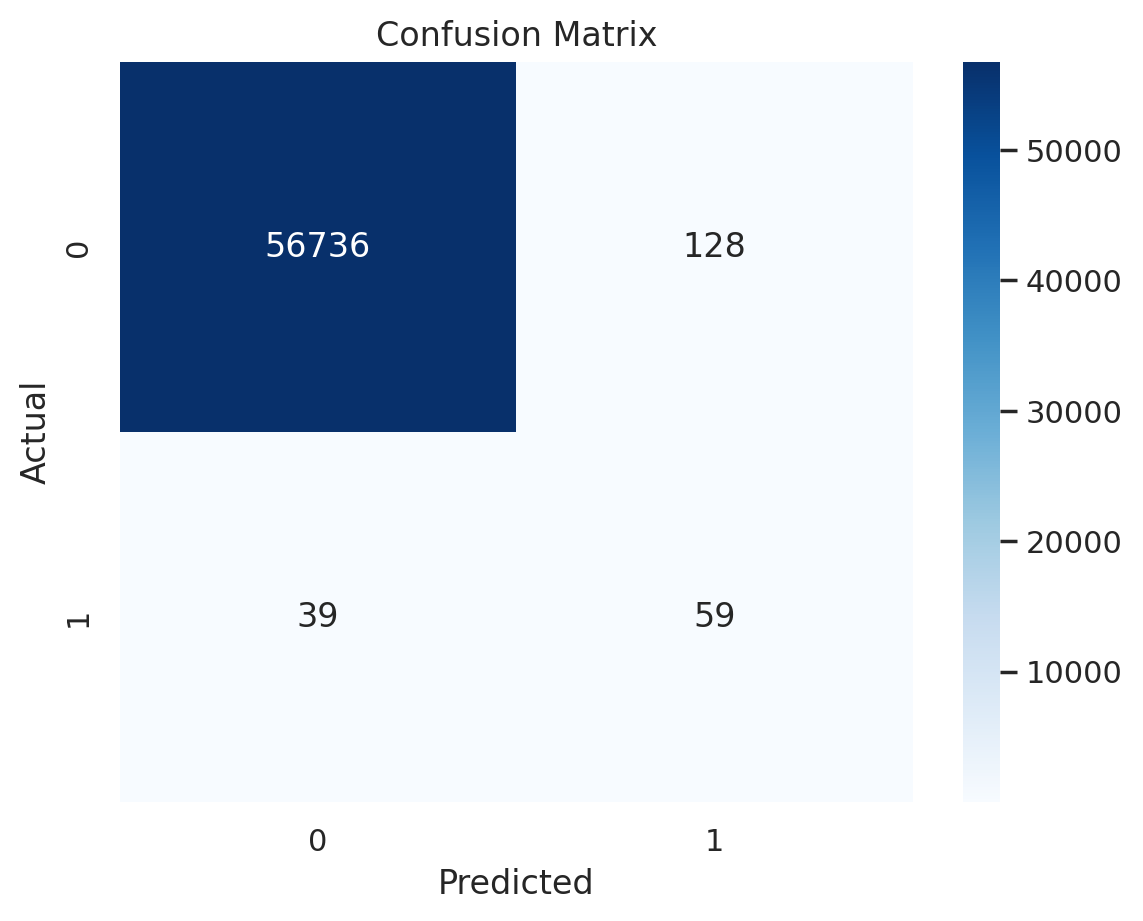

In [83]:
### classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_lable, predicted))
plot_confusion_matrix(true_lable, predicted)

ann_report = classification_report(true_lable, predicted, output_dict=True)

4/4 [==============================] - 0s 2ms/step


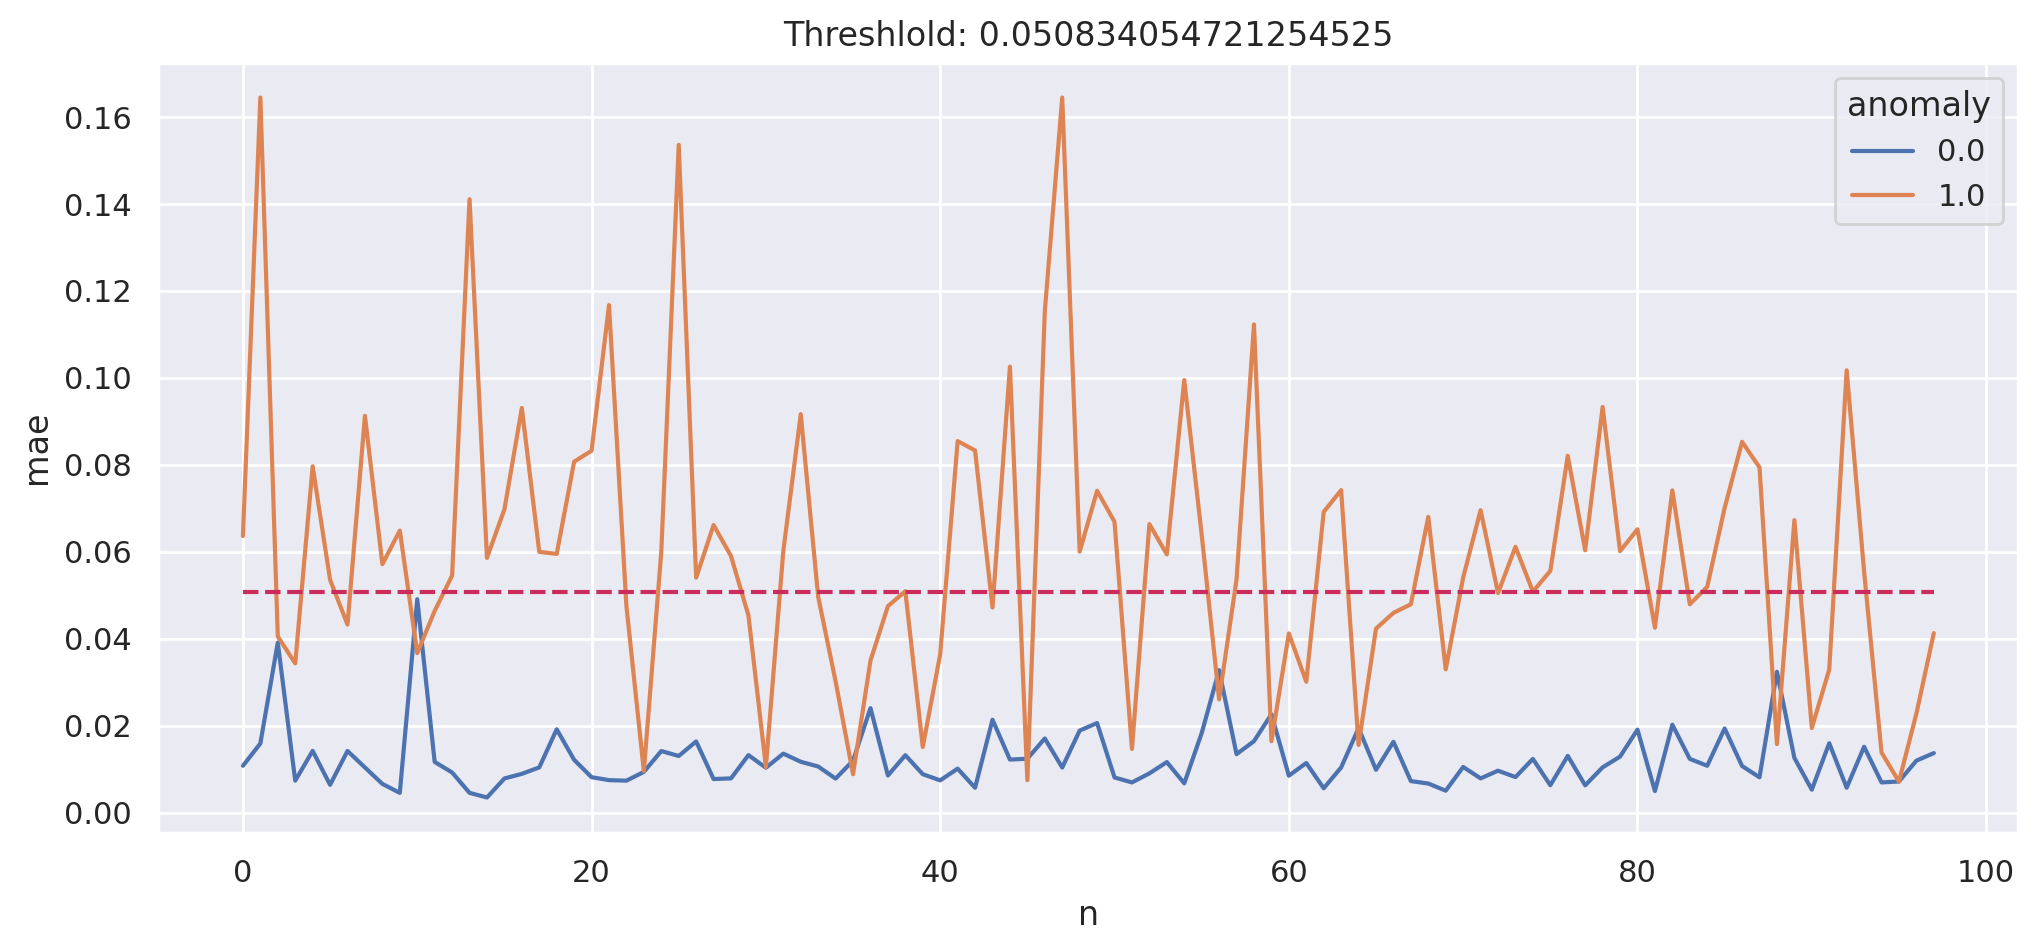

In [84]:
from matplotlib import lines
plot_samples = 98
plt.figure(figsize=(12,5))

# normal event
n_features = 25
real_x = normal_test_data[:plot_samples]
predicted_x = autoencoder.predict(x=real_x)
normal_events_mae = losses.mae(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mae': normal_events_mae,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})


# abnormal event
abnormal_x = fraud_test_data[:plot_samples]
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mae = losses.mae(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mae': abnormal_events_mae,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})
abnormal_events_df

mae_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mae_df.n, y=mae_df.mae, hue=mae_df.anomaly)

line = lines.Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off_1),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off_1))
plt.show()

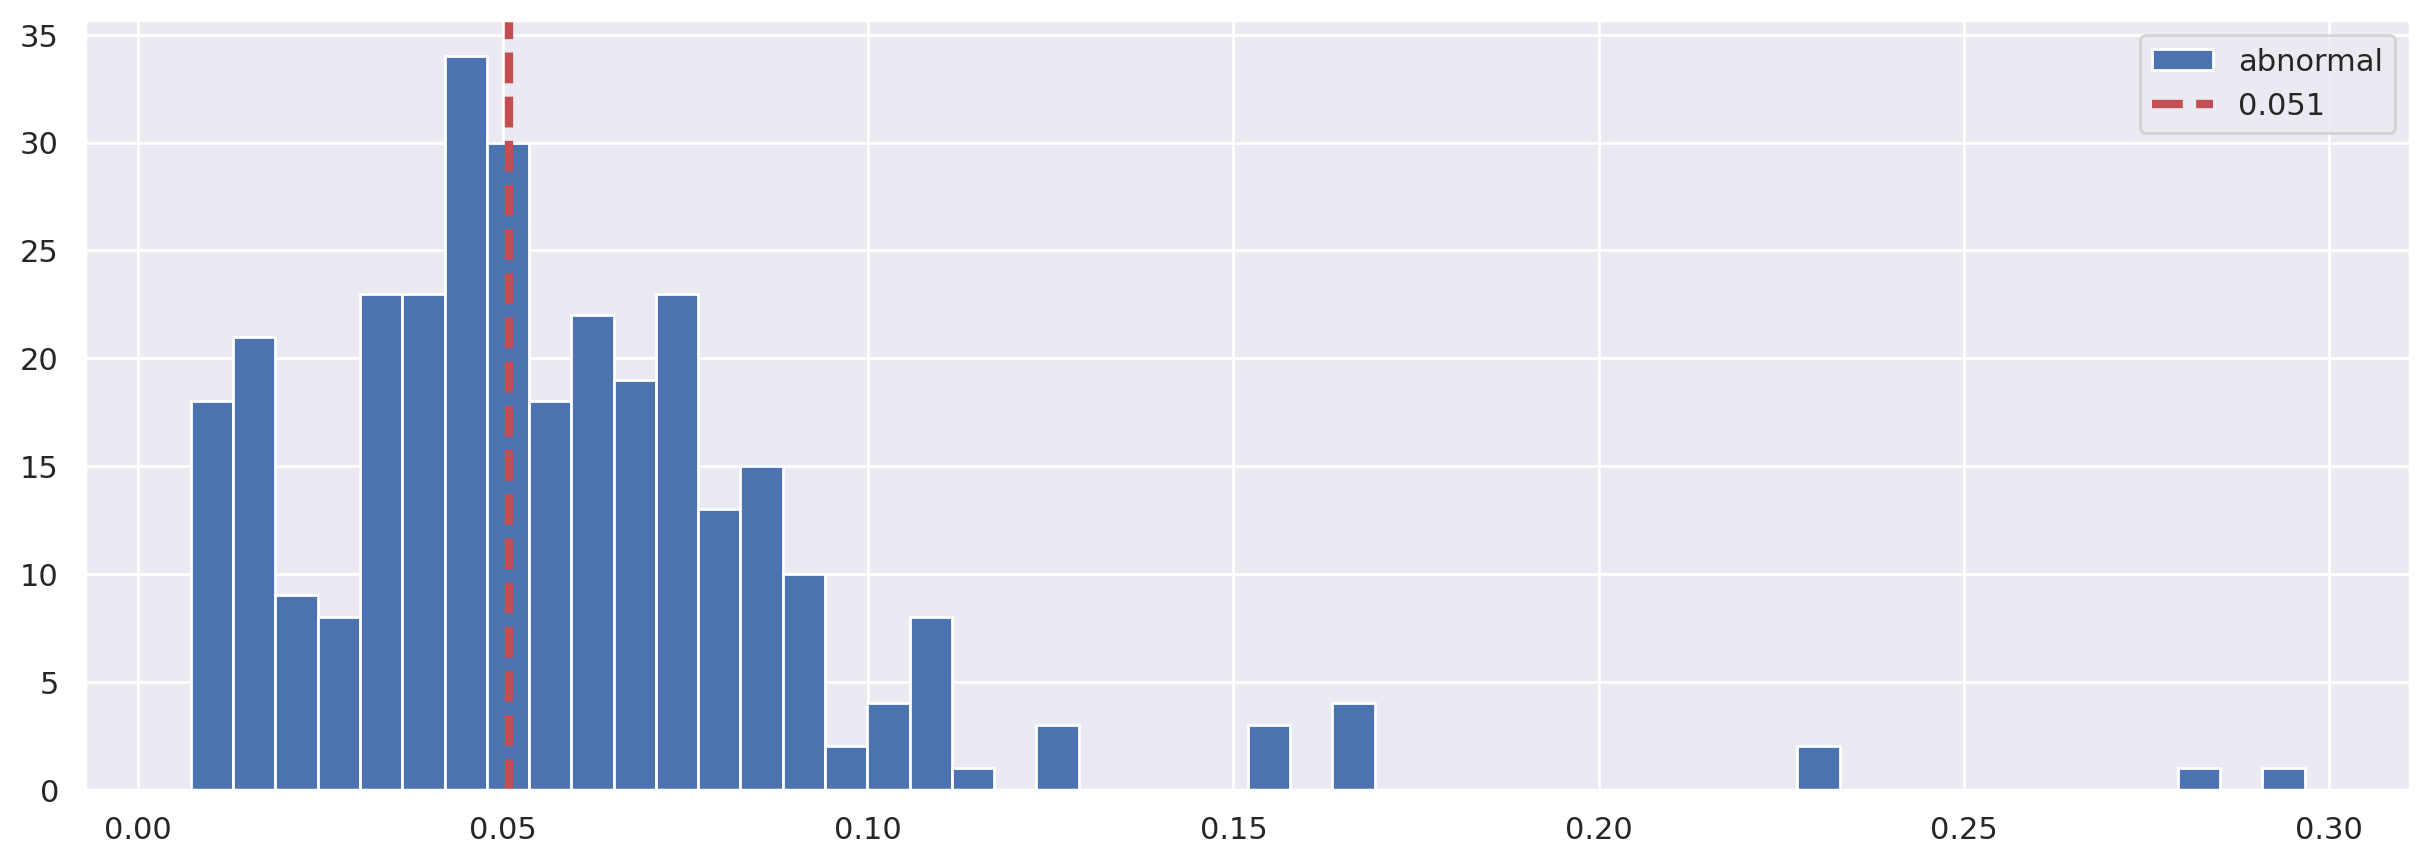

In [85]:
plt.figure(figsize=(15,5))

# plt.hist(train_normal_loss, bins = 50, label = 'normal')
plt.hist(train_fraud_loss, bins = 50, label = 'abnormal')
plt.axvline(cut_off_1, color = 'r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(cut_off_1))
plt.legend(loc = 'upper right')
plt.show()

## Isolation Forest

# Isolation Forest


The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

In [86]:
df = dataframe.copy()

In [87]:
train_X, train_y, test_X, test_y = get_data(df)

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283823
Test Samples: 984


## Train on only Normal dataset

In [88]:
from sklearn.ensemble import IsolationForest

In [89]:
model = IsolationForest(random_state=seed)
model.fit(train_X)

IsolationForest(random_state=1337)

In [90]:
def predict(X):
    test_yhat = model.predict(X)
    # values are -1 and 1 (-1 for outliers and 1 for inliers), thus we will map it to 0 (inlier) and 1 (outlier) as this is our target variable
    test_yhat = np.array([1 if y == -1 else 0 for y in test_yhat])
    return test_yhat

In [91]:
test_yhat = predict(test_X)

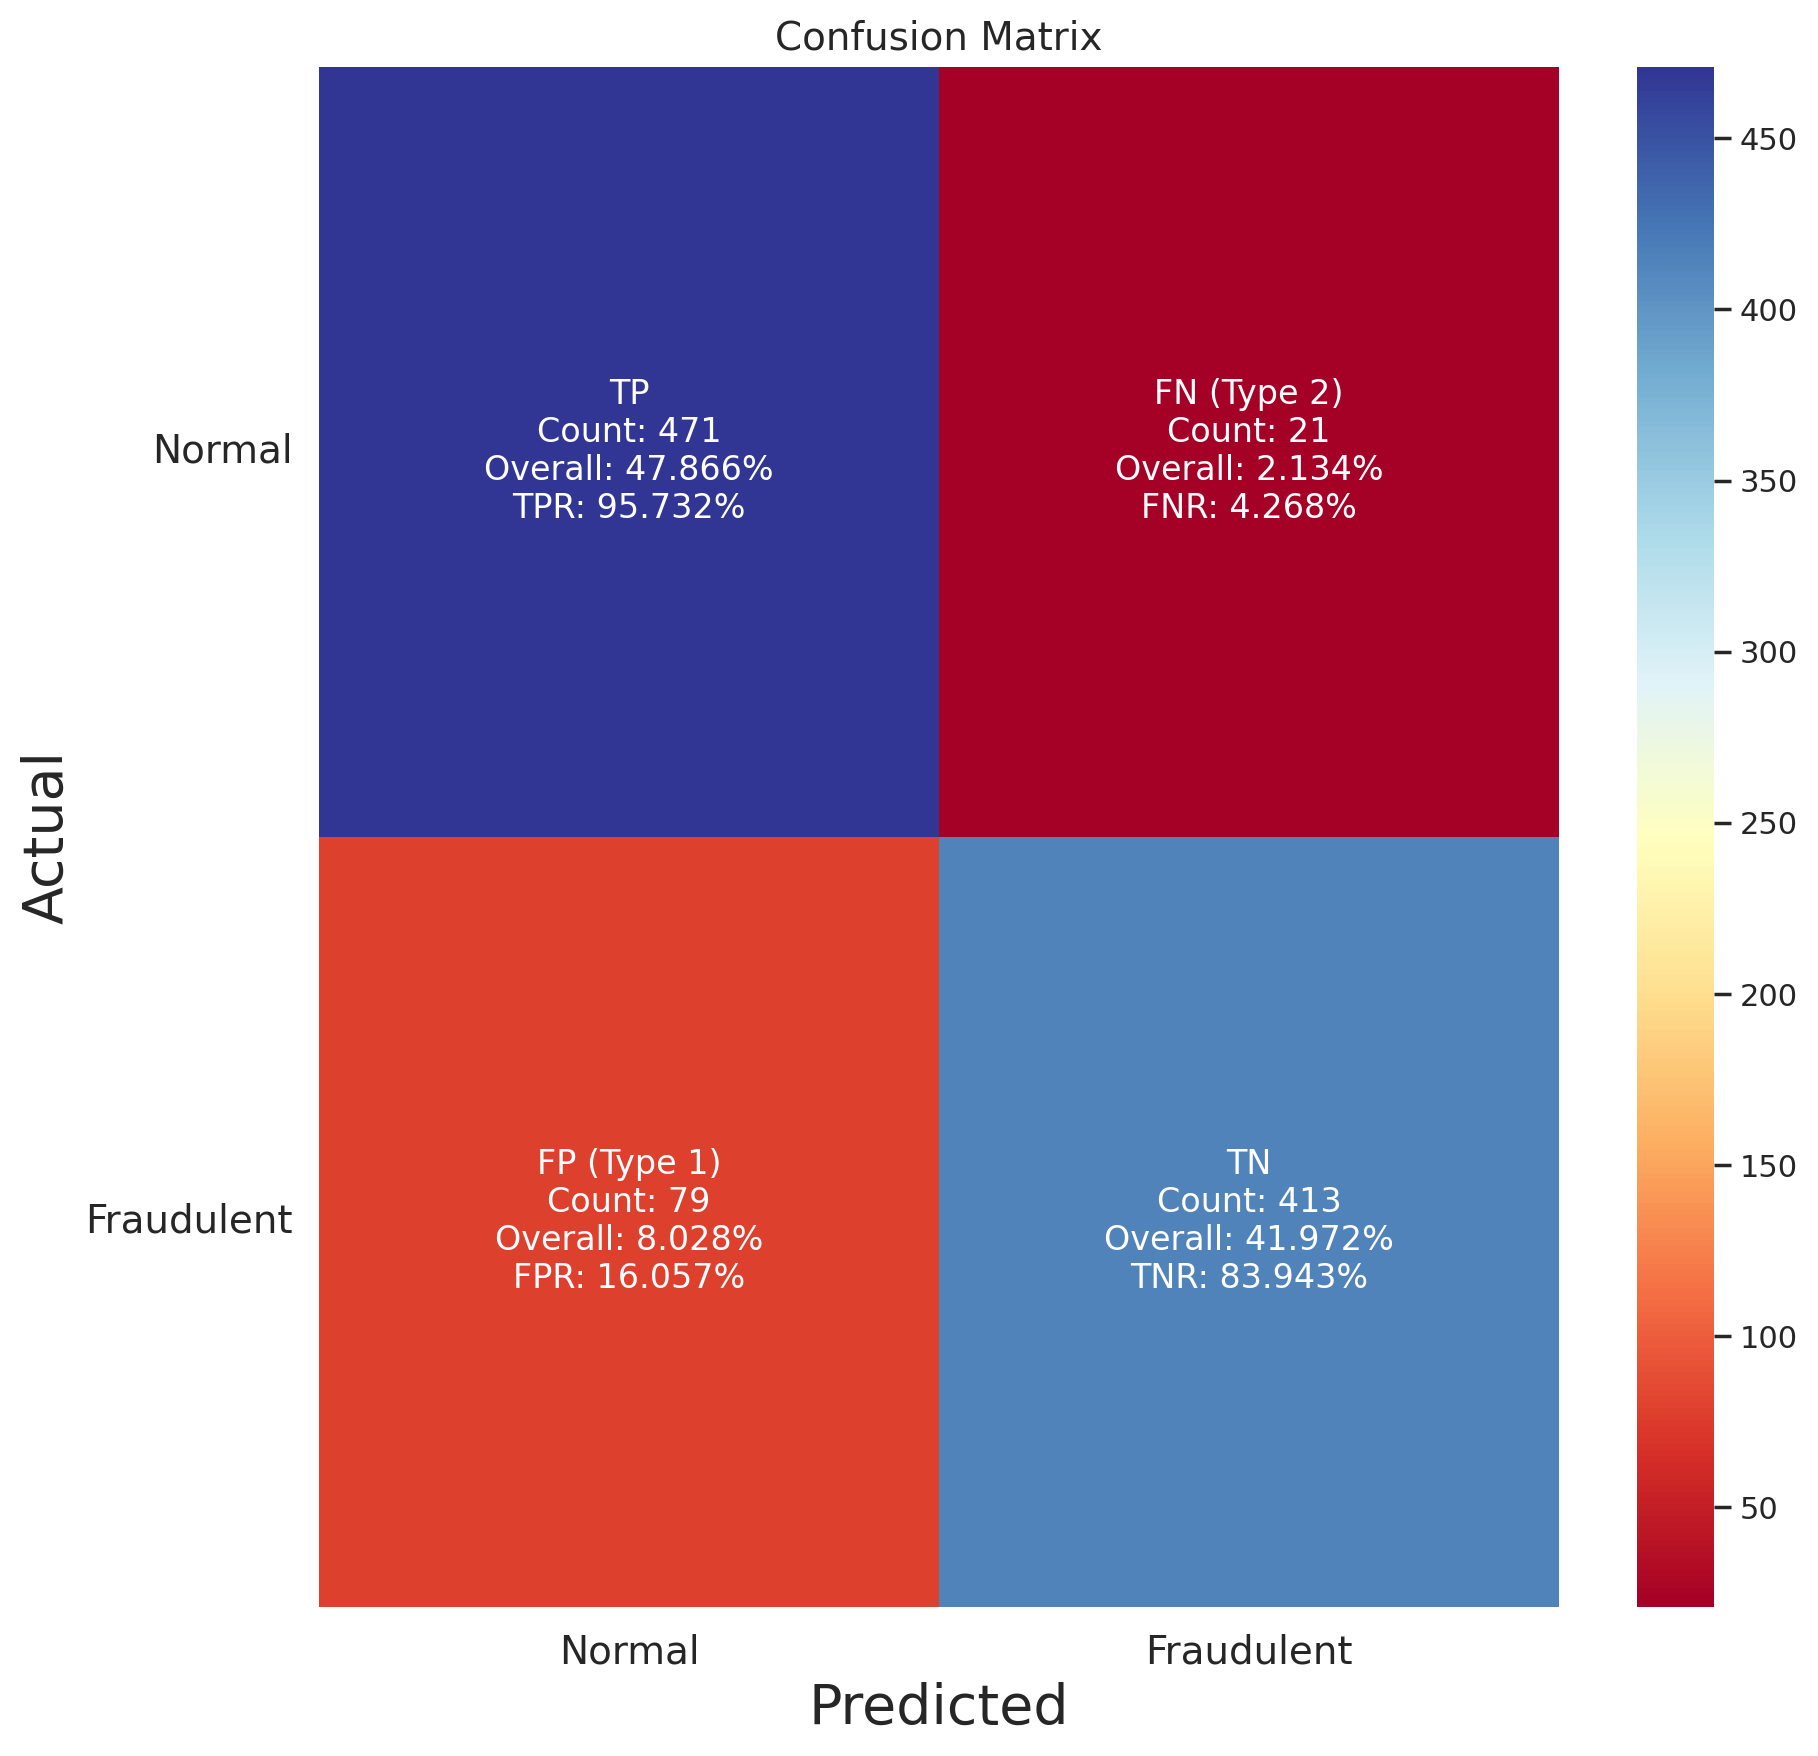

In [92]:
get_confusion_matrix(test_y, test_yhat)

In [93]:
def get_classification_report(test_y, test_yhat):
    labels = ['Normal','Fraudulent']
    print(classification_report(test_y, test_yhat, target_names=labels))

In [94]:
get_classification_report(test_y, test_yhat)

if_report = classification_report(test_y, test_yhat, output_dict=True)

              precision    recall  f1-score   support

      Normal       0.86      0.96      0.90       492
  Fraudulent       0.95      0.84      0.89       492

    accuracy                           0.90       984
   macro avg       0.90      0.90      0.90       984
weighted avg       0.90      0.90      0.90       984



## Training on Both Normal and fraud dataset

In [95]:
train_X, train_y, test_X, test_y = get_data(df, clean_train=False)

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283824
Test Samples: 983


In [96]:
model = IsolationForest(random_state=seed)
model.fit(train_X, train_y)

IsolationForest(random_state=1337)

In [97]:
test_yhat = predict(test_X)

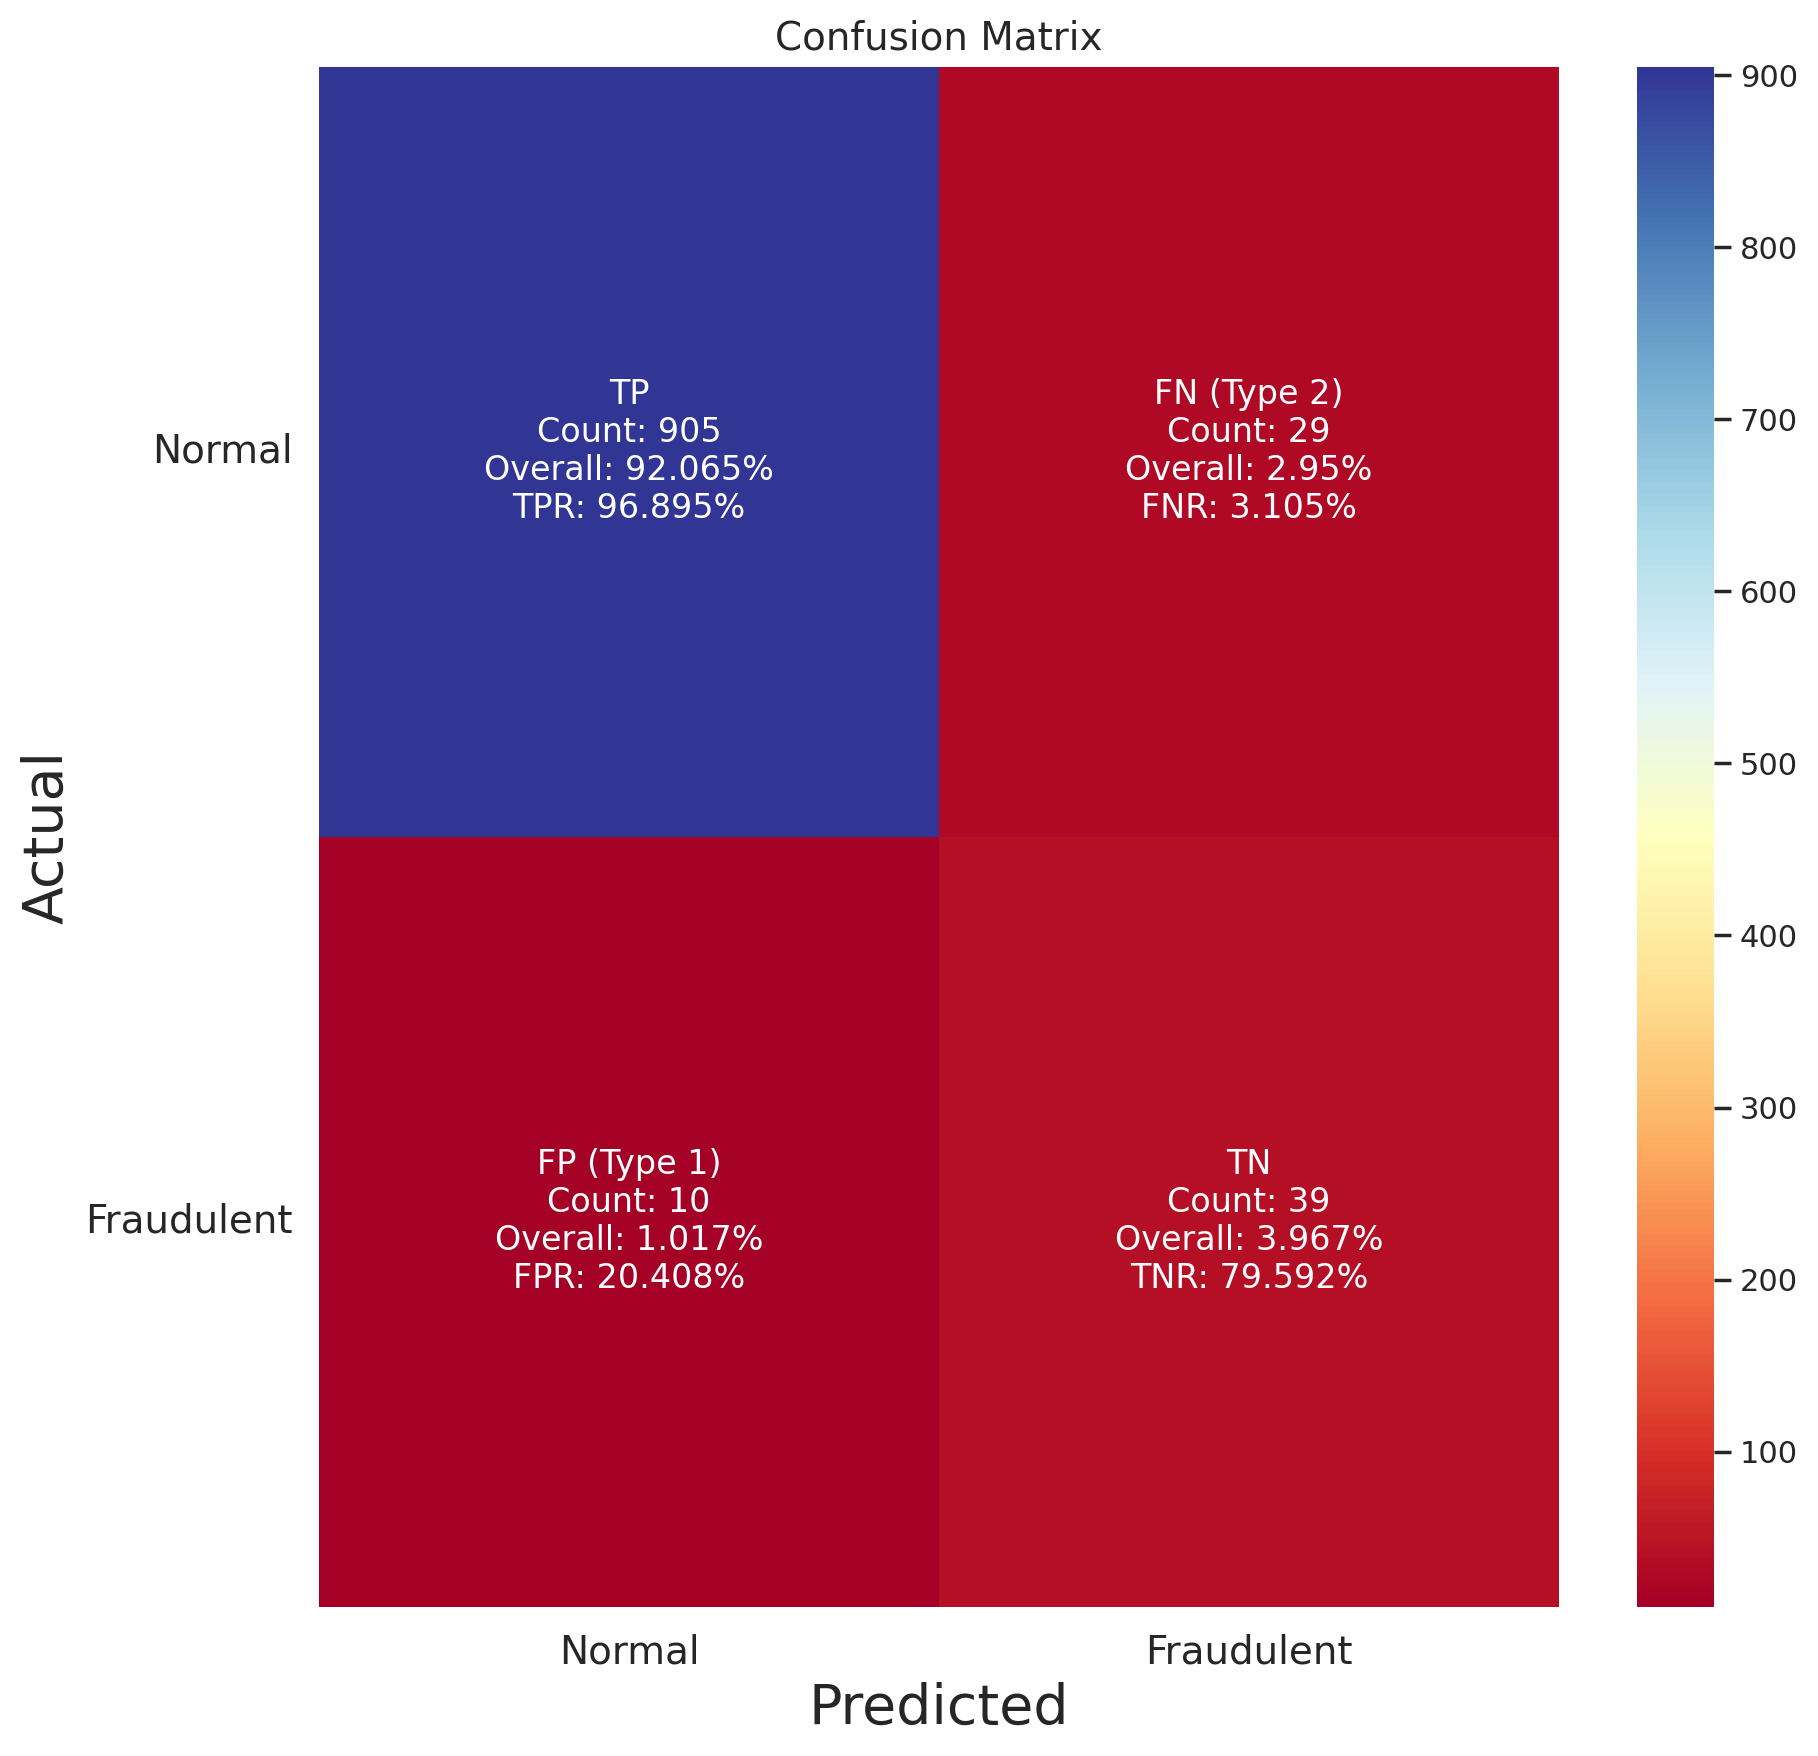

In [98]:
get_confusion_matrix(test_y, test_yhat)

In [99]:
get_classification_report(test_y, test_yhat)

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       934
  Fraudulent       0.57      0.80      0.67        49

    accuracy                           0.96       983
   macro avg       0.78      0.88      0.82       983
weighted avg       0.97      0.96      0.96       983



Here, when we train on both normal and fruad dataset the prediction becomes worse

# CBLOF

In [100]:
!pip install pyod

Seperate Labels from feature value

In [101]:
df = dataframe.copy()

In [102]:
# Separate features and labels
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

Scale the feature values

In [103]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [104]:
from pyod.models.cblof import CBLOF

# Initialize the CBLOF model
cblof = CBLOF(contamination=0.0017, random_state=42)

In [105]:
# Fit the model
cblof.fit(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.0017, n_clusters=8, n_jobs=None, random_state=42,
   use_weights=False)

In [106]:
# Get the outlier scores
y_pred = cblof.labels_  # binary labels (0: inliers, 1: outliers)
y_scores = cblof.decision_scores_  # raw outlier scores

In [107]:
len(y_pred[y_pred==1])

485

In [108]:
y_scores

array([2.94239611, 2.5304031 , 5.95090084, ..., 4.26433481, 5.64534081,
       3.07509567])

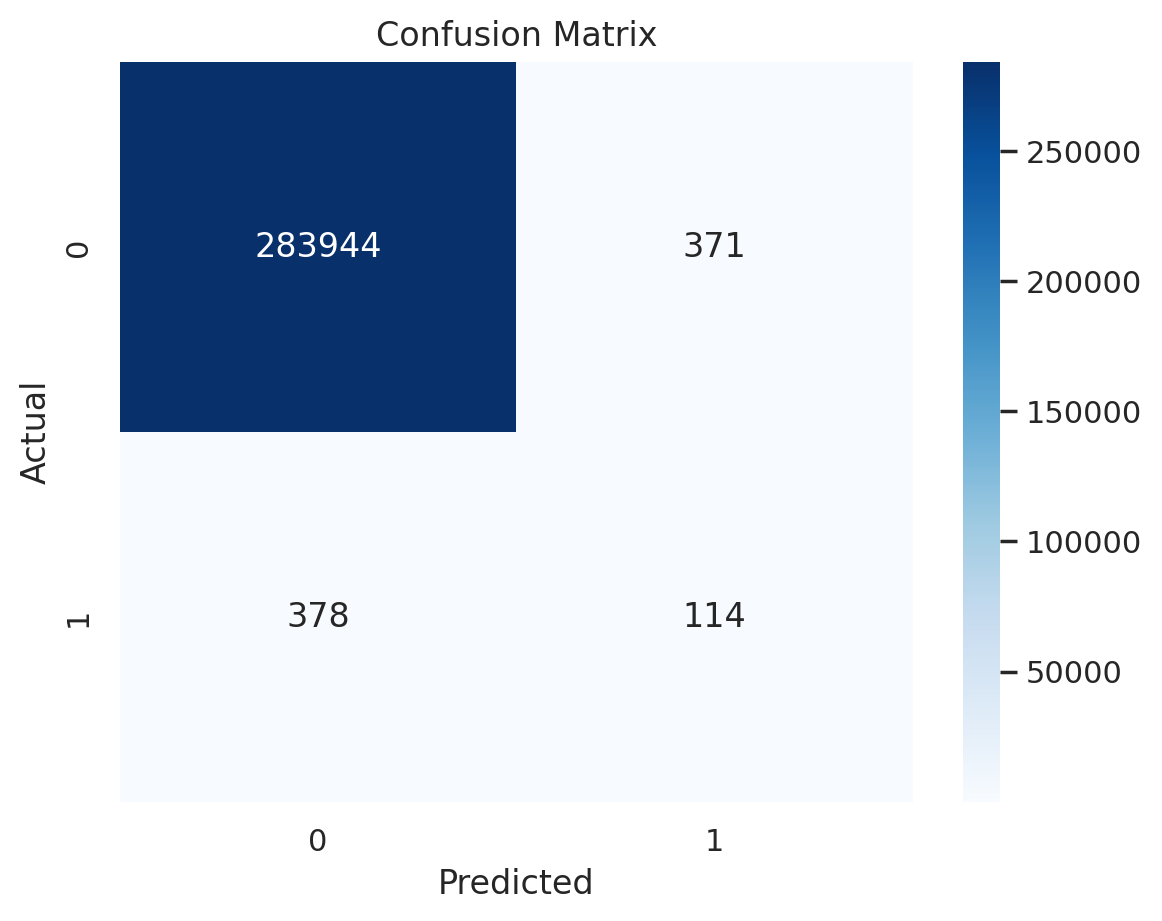

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.24      0.23      0.23       492

    accuracy                           1.00    284807
   macro avg       0.62      0.62      0.62    284807
weighted avg       1.00      1.00      1.00    284807



In [109]:
# Evaluate the model
plot_confusion_matrix(y, y_pred)
print(classification_report(y, y_pred))

cblof_report = classification_report(y, y_pred, output_dict=True)

# DBSCAN

In [110]:
import scipy
from pylab import rcParams
import itertools

rcParams['figure.figsize'] = 14, 8

# Answer to the Ultimate Question of Life, the Universe, and Everything
RANDOM_SEED = 42

LABELS = ["Normal", "Fraud"]

Now plot Transaction class distribution

In [111]:
df = dataframe.copy()

In [112]:

# Take a sample of data
data_sample = df.sample(frac=0.1, random_state=1)
# data_sample = data

data_sample.shape

(28481, 31)

In [113]:
# Now we do the rest operation with this sample data to reduce processing
Fraud = data_sample[data_sample['Class']==1]
Valid = data_sample[data_sample['Class']==0]

# Find the ration of Outlier to Normal
outlier_fraction = len(Fraud)/float(len(Valid))

print(outlier_fraction)
print(len(Fraud))
print(len(Valid))

0.0017234102419808666
49
28432


In [114]:
# Create independent and dependent features

# create a list of column names
columns = data_sample.columns.to_list()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ['Class','V15','V17','V24','V27','Time']]

# Define a random state
# state = np.random.RandomState(42)

X = data_sample[columns]
Y = data_sample['Class']

# print(state)
print(X.columns)
print(X.shape)
print(Y.shape)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V16', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23',
       'V25', 'V26', 'V28', 'Amount'],
      dtype='object')
(28481, 25)
(28481,)


In [115]:
##### here we are going to use min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit(X)
X_scaled = data_scaled.transform(X)

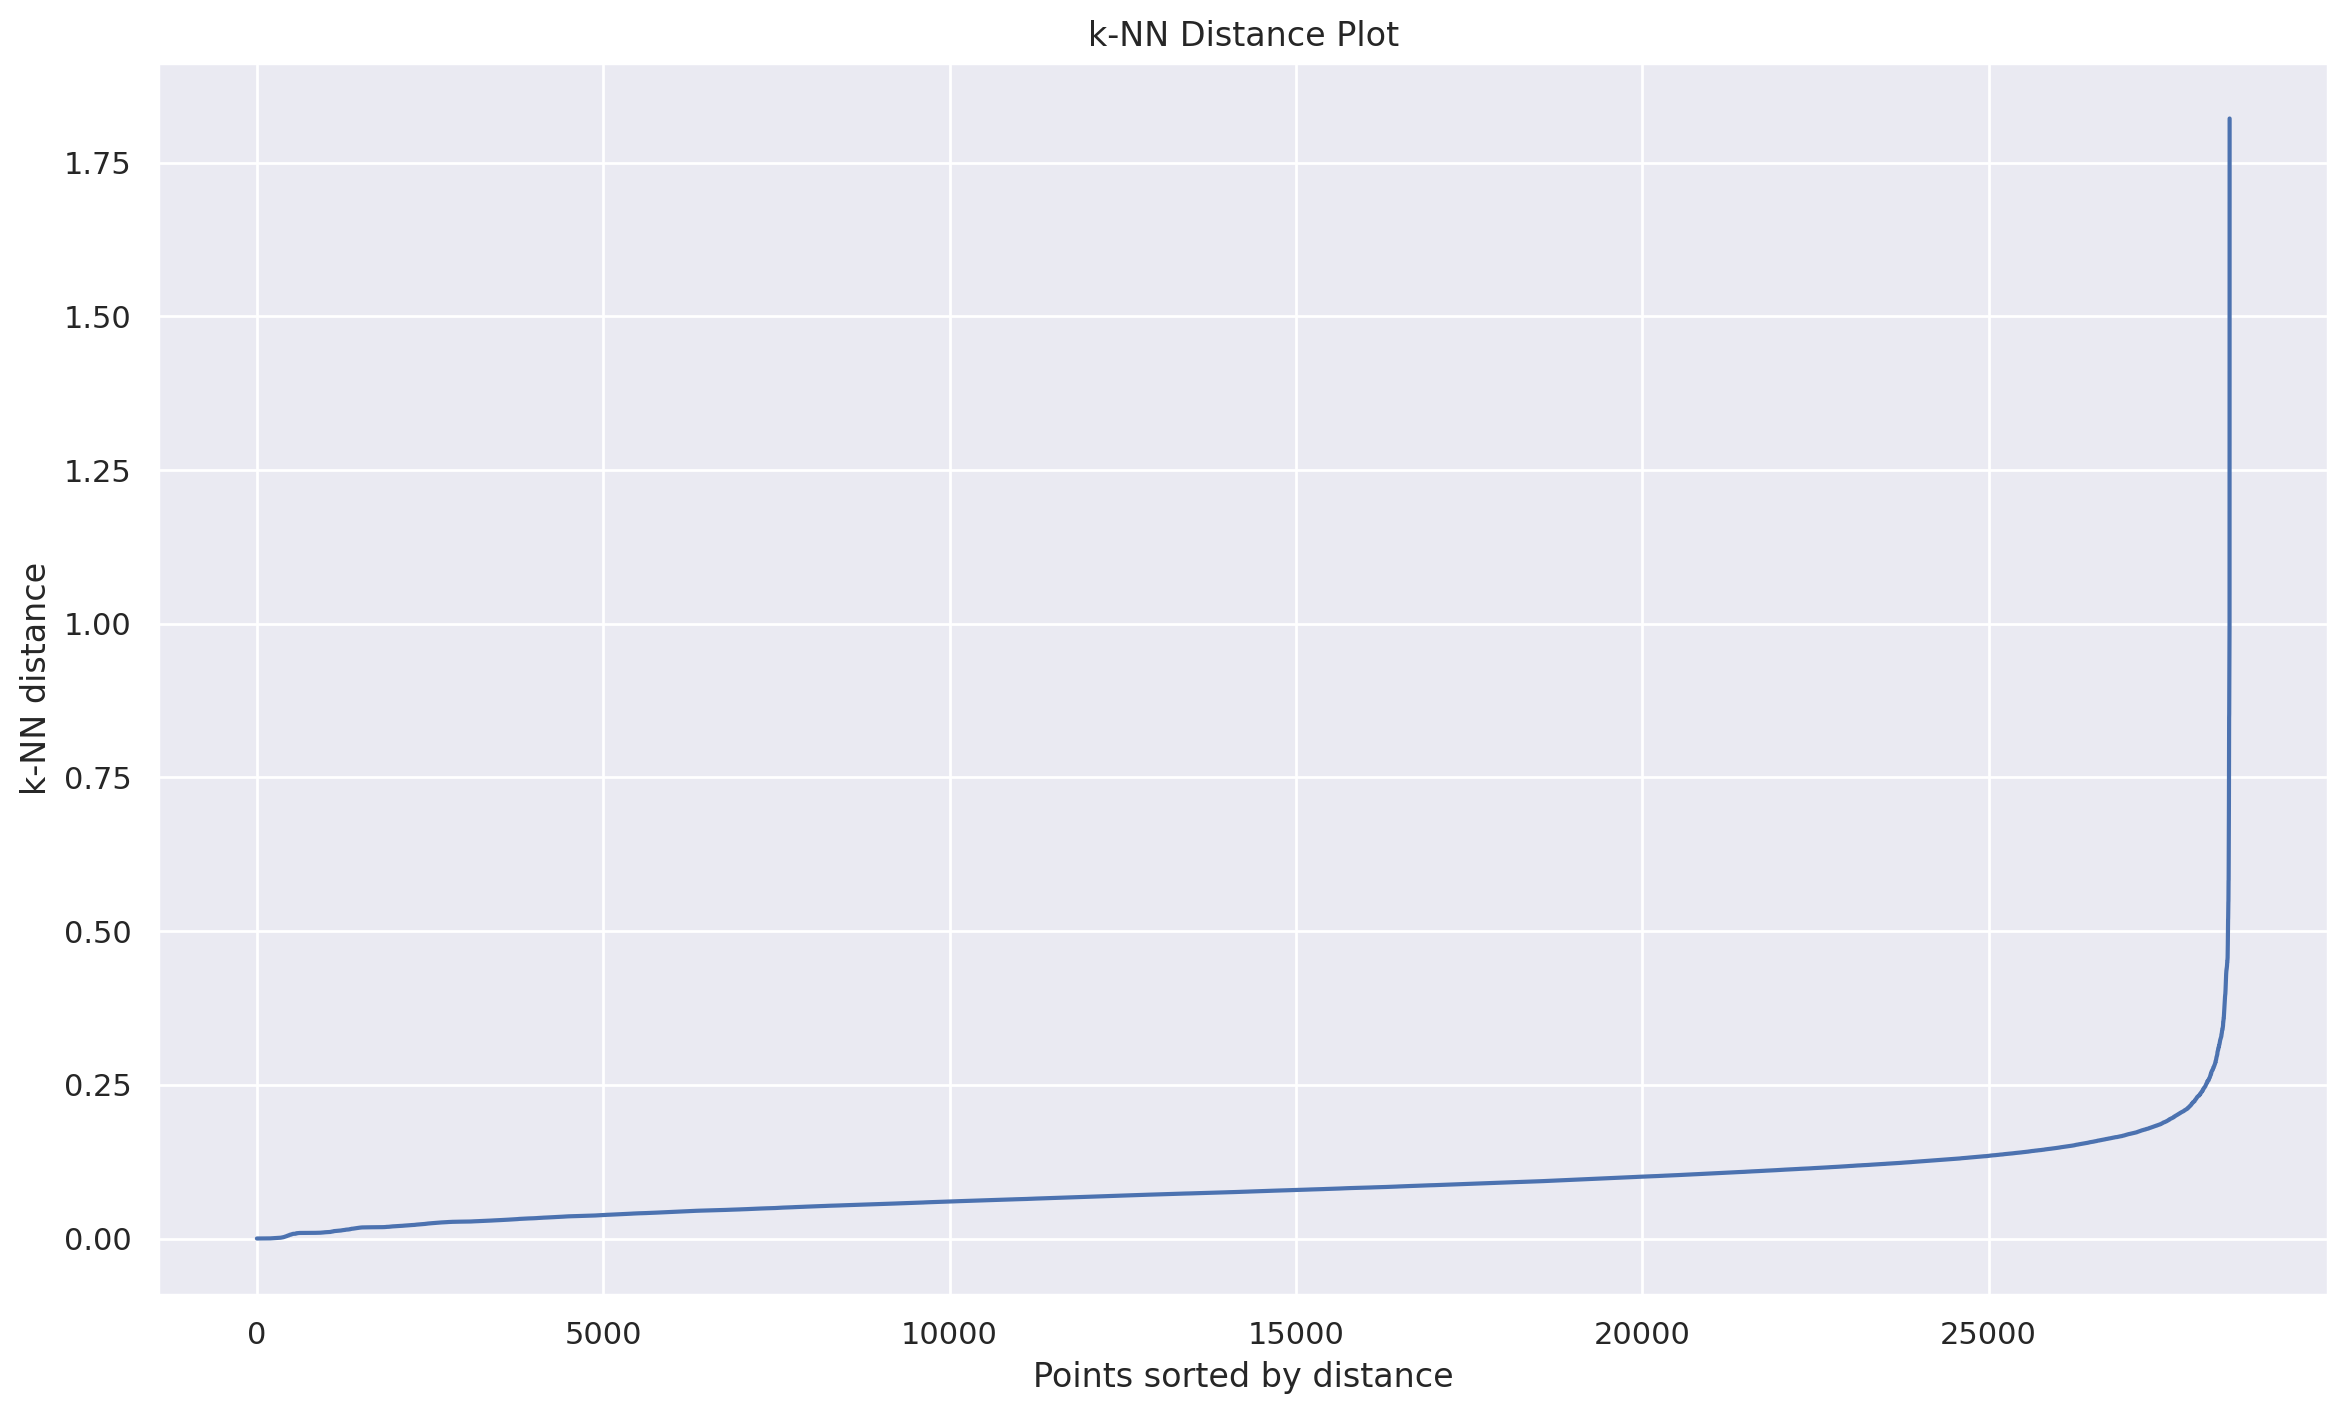

In [116]:
from sklearn.neighbors import NearestNeighbors


# Step 1: Calculate the k-nearest neighbors
k = 4  # k is usually set to min_samples - 1
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Step 2: Sort the distances (4th column)
distances = np.sort(distances[:, k-1], axis=0)

# Step 3: Plot the distances
plt.plot(distances)
plt.ylabel('k-NN distance')
plt.xlabel('Points sorted by distance')
plt.title('k-NN Distance Plot')
plt.show()

# The "elbow" point is a good candidate for `eps`

In [117]:
from sklearn.cluster import DBSCAN

In [118]:
# Create DBSCAN object
dbscan = DBSCAN(eps=0.5, min_samples=10)
# Fitting the model
model = dbscan.fit(X_scaled)

In [119]:
# classification result as labels
labels = model.labels_

In [120]:
# Find unique values
unique_values = np.unique(labels)

# Print unique values
print(unique_values)

[-1  0]


In [121]:
outlier_indices = np.where(labels == -1)[0]
print(len(outlier_indices))

25


In [122]:
"""ONLY RUN THIS ONCE"""
#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
prediction = np.where(labels == -1, 1, 0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.32      0.16      0.22        49

    accuracy                           1.00     28481
   macro avg       0.66      0.58      0.61     28481
weighted avg       1.00      1.00      1.00     28481



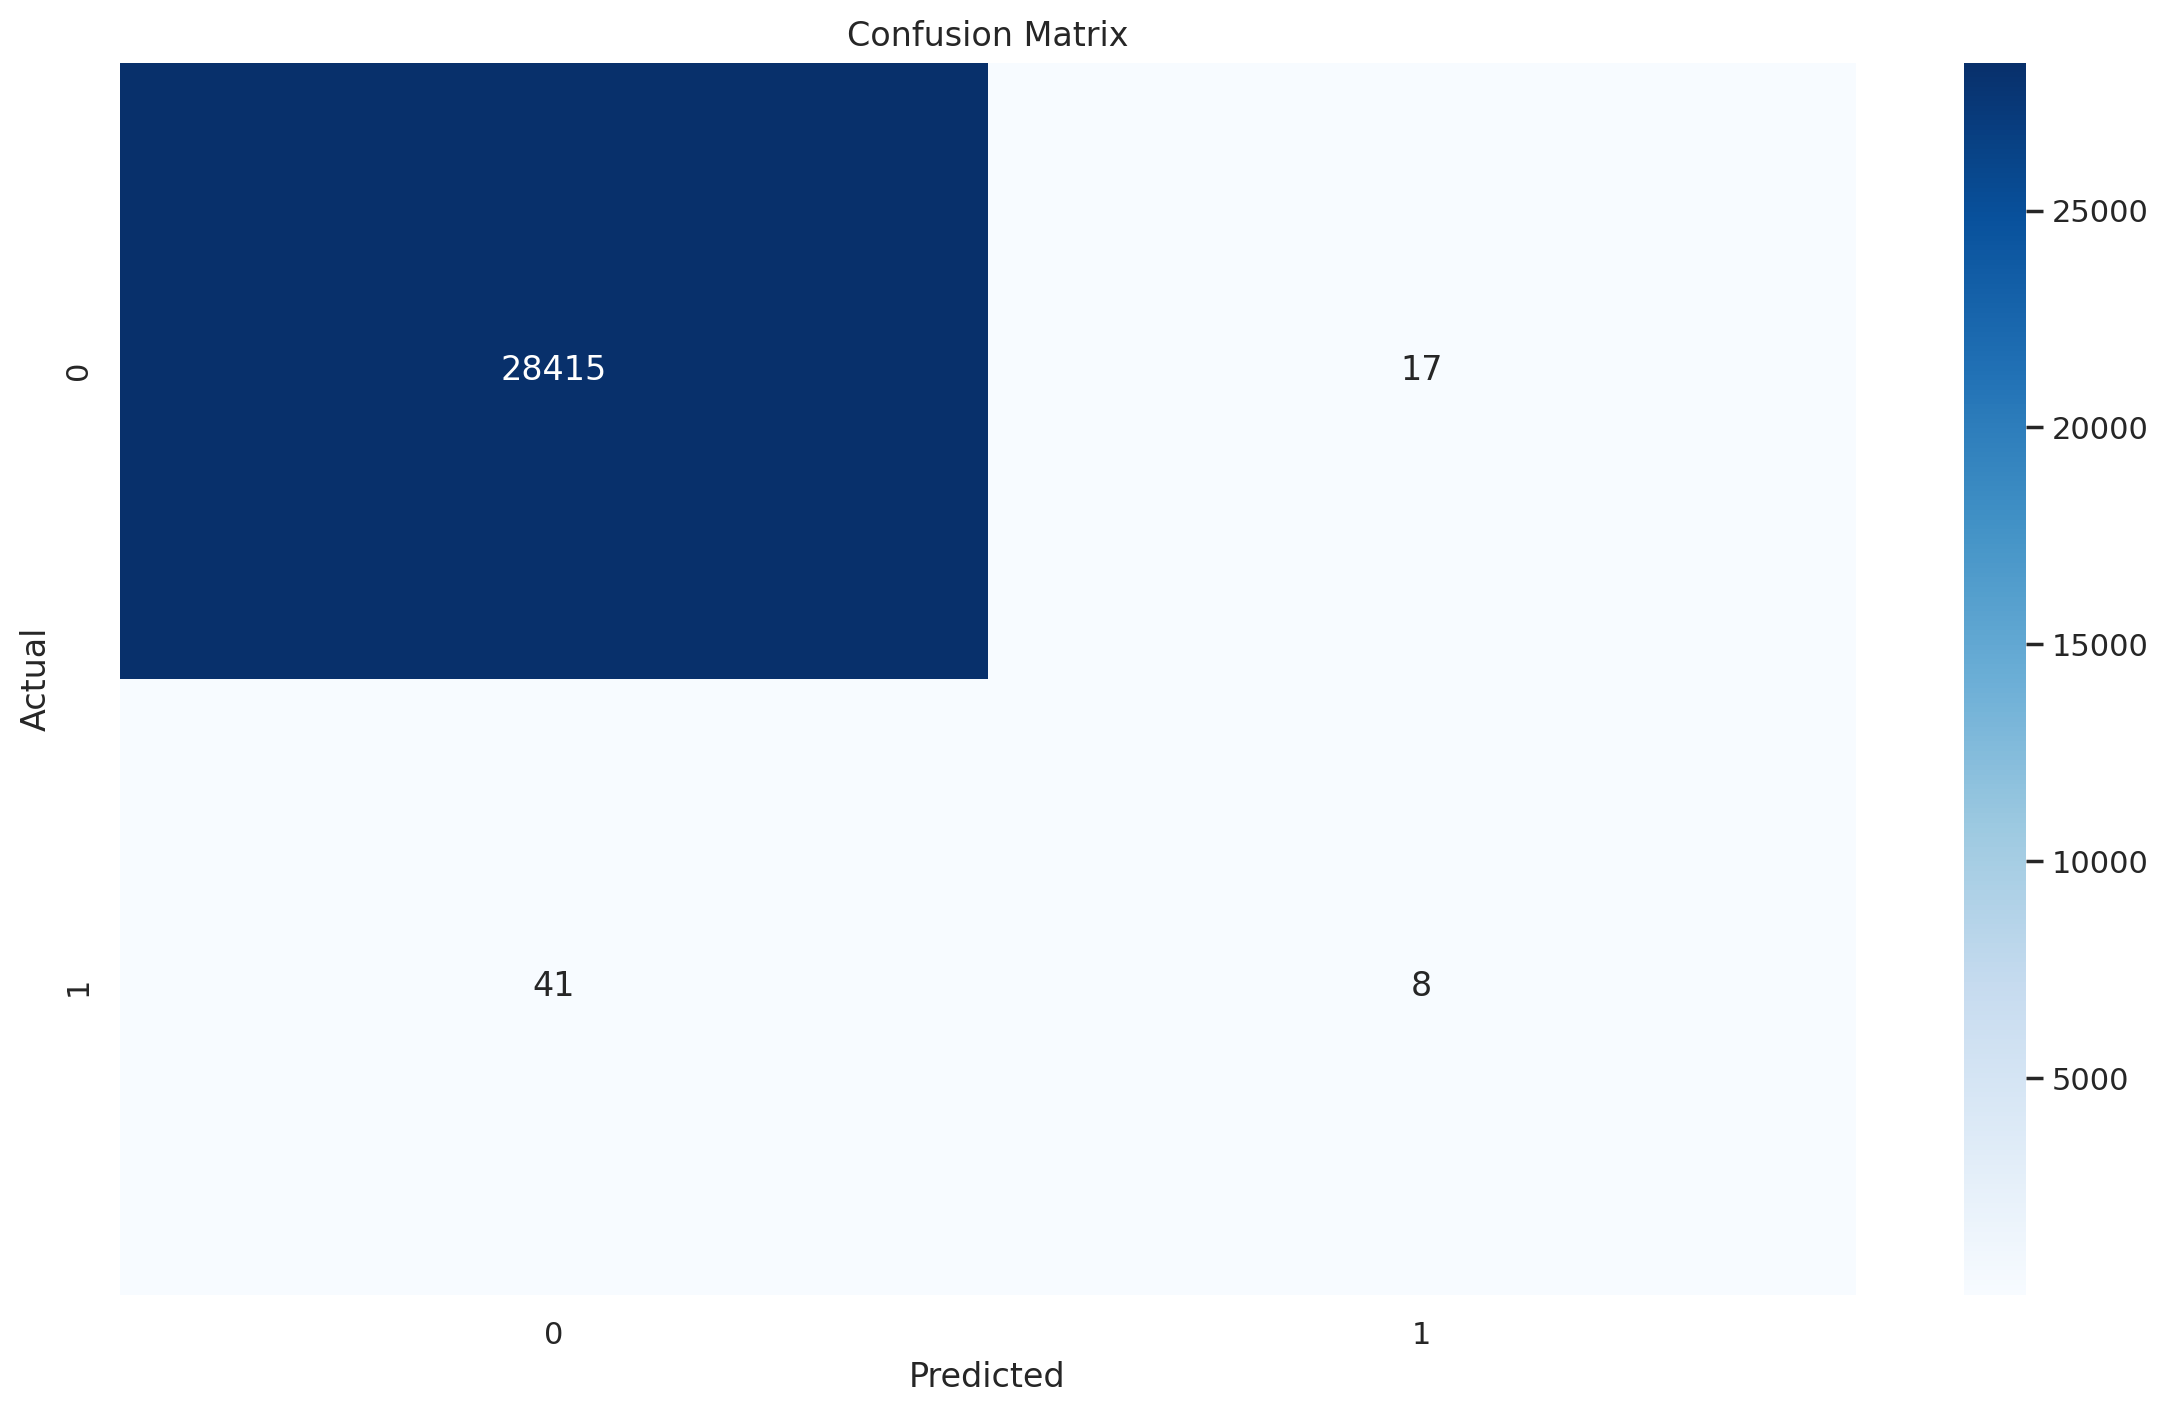

In [123]:
### classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y, prediction))

dbscan_report = classification_report(Y, prediction, output_dict=True)

plot_confusion_matrix(Y, prediction)

In [124]:
### classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y, prediction))
print(confusion_matrix(Y, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.32      0.16      0.22        49

    accuracy                           1.00     28481
   macro avg       0.66      0.58      0.61     28481
weighted avg       1.00      1.00      1.00     28481

[[28415    17]
 [   41     8]]


# GMM

In [125]:
# Model
from sklearn.mixture import GaussianMixture

In [126]:
df = dataframe.copy()

In [127]:
# Take a sample of data
data_sample = df.sample(frac=0.1, random_state=1)

data_sample.shape

(28481, 31)

In [128]:
# Count fraudulent transactions (Class = 1)
num_fraudulent = data_sample['Class'].value_counts().get(1, 0)

# Count normal transactions (Class = 0)
num_normal = data_sample['Class'].value_counts().get(0, 0)

# Calculate the ratio
if num_normal > 0:
    ratio = num_fraudulent / num_normal
else:
    ratio = float('inf')  # Avoid division by zero if there are no normal transactions

print(f'Number of fraudulent transactions: {num_fraudulent}')
print(f'Number of normal transactions: {num_normal}')
print(f'Ratio of fraudulent to normal transactions: {ratio: f}')

Number of fraudulent transactions: 49
Number of normal transactions: 28432
Ratio of fraudulent to normal transactions:  0.001723


In [129]:
y = data_sample['Class']
X = data_sample.drop(['Time', 'Class'], axis=1)

In [130]:
len(data_sample[data_sample['Class']==1])

49

In [131]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [132]:
# Define the range for n_components
n_components_range = range(1, 11)

# Lists to store the BIC and AIC scores
bic_scores = []
aic_scores = []

# Fit GMM for each n_components and calculate BIC and AIC
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, n_init=5, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

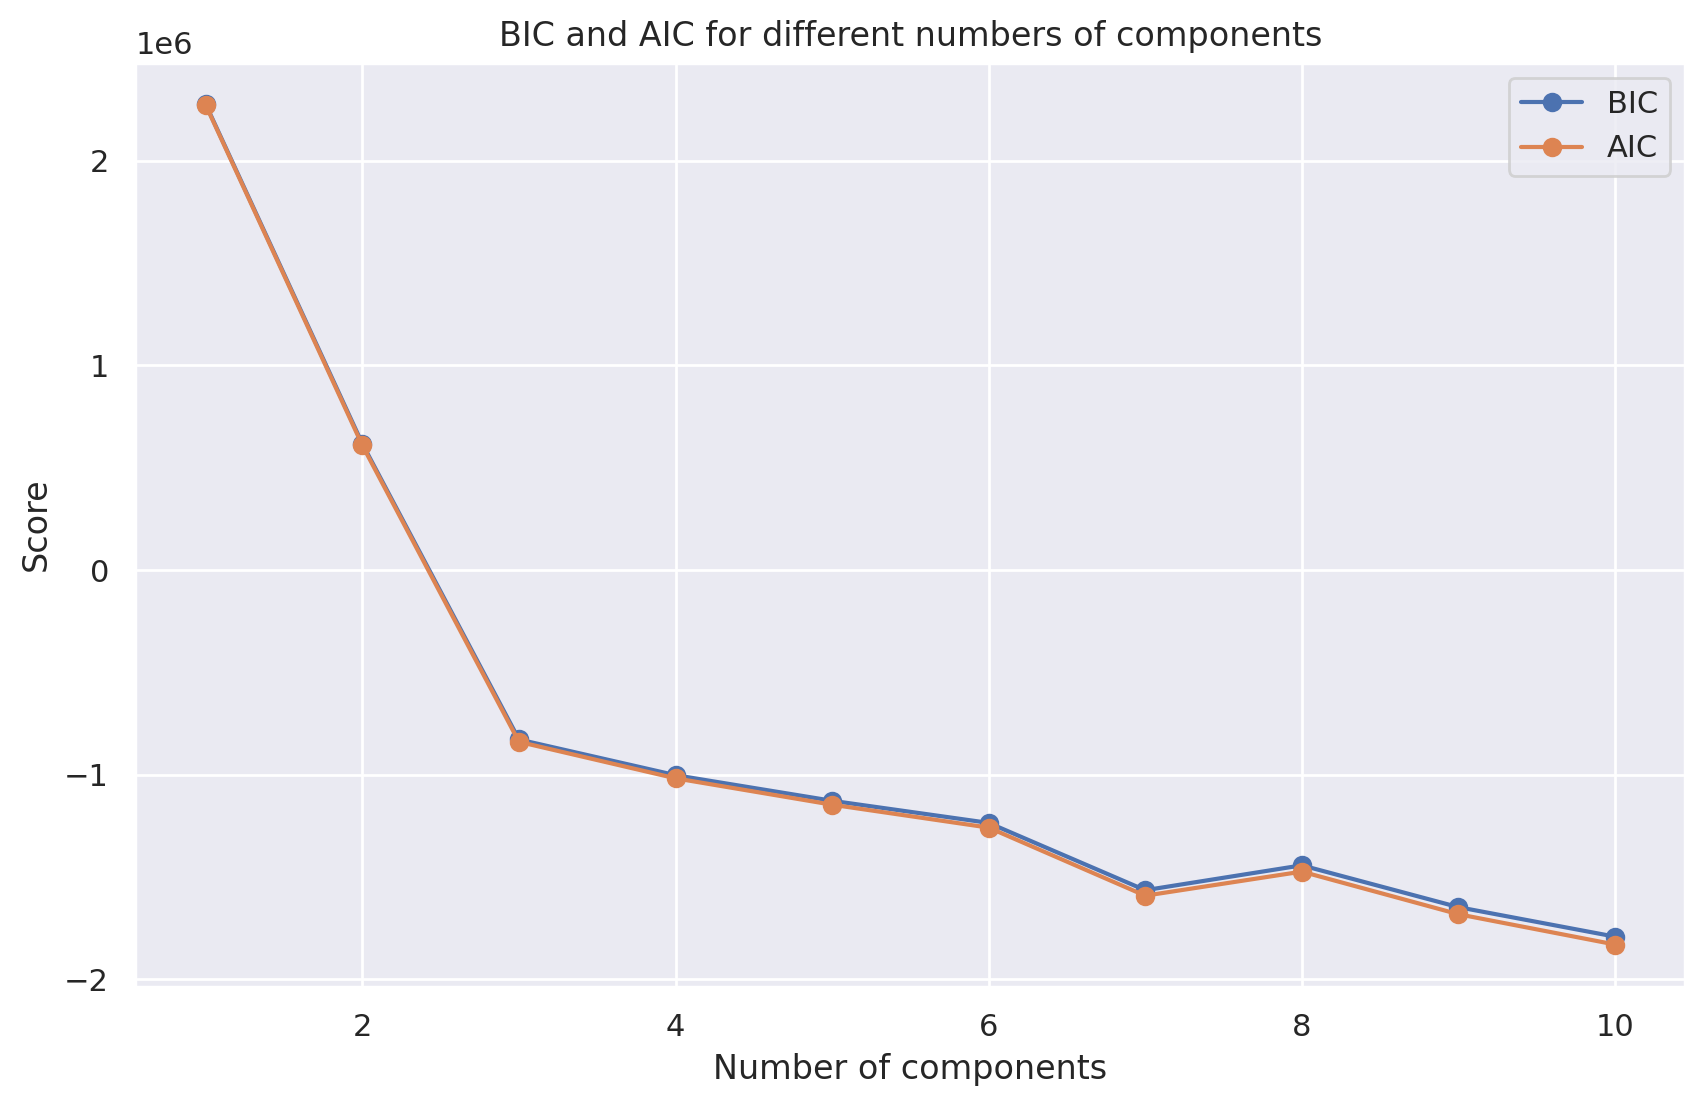

In [133]:
# Plot BIC and AIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('BIC and AIC for different numbers of components')
plt.legend()
plt.show()

In [134]:
# Fit GMM model
gmm = GaussianMixture(n_components=6, n_init=5, random_state=42)
y_gmm = gmm.fit(X_scaled)

In [135]:
data_sample

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
169876,119907.0,-0.611712,-0.769705,-0.149759,-0.224877,2.028577,-2.019887,0.292491,-0.523020,0.358468,...,-0.075208,0.045536,0.380739,0.023440,-2.220686,-0.201146,0.066501,0.221180,1.79,0
127467,78340.0,-0.814682,1.319219,1.329415,0.027273,-0.284871,-0.653985,0.321552,0.435975,-0.704298,...,-0.128619,-0.368565,0.090660,0.401147,-0.261034,0.080621,0.162427,0.059456,1.98,0
137900,82382.0,-0.318193,1.118618,0.969864,-0.127052,0.569563,-0.532484,0.706252,-0.064966,-0.463271,...,-0.305402,-0.774704,-0.123884,-0.495687,-0.018148,0.121679,0.249050,0.092516,0.89,0
21513,31717.0,-1.328271,1.018378,1.775426,-1.574193,-0.117696,-0.457733,0.681867,-0.031641,0.383872,...,-0.220815,-0.419013,-0.239197,0.009967,0.232829,0.814177,0.098797,-0.004273,15.98,0
134700,80923.0,1.276712,0.617120,-0.578014,0.879173,0.061706,-1.472002,0.373692,-0.287204,-0.084482,...,-0.160161,-0.430404,-0.076738,0.258708,0.552170,0.370701,-0.034255,0.041709,0.76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,1574.0,-0.615776,0.654356,2.618793,0.857434,-0.487340,0.593957,-0.095191,0.426786,0.011607,...,0.010440,0.113631,-0.313035,-0.015388,0.213878,-0.268579,0.117815,0.075734,9.99,0
240932,150813.0,-3.517229,3.326821,-3.590262,0.674769,-0.679266,-0.469516,-1.135362,2.778095,-2.404956,...,0.455767,0.388102,0.268986,0.382692,-0.653335,2.192962,-0.953907,-0.137082,0.76,0
3701,3169.0,-0.315540,1.054303,1.484711,1.138262,0.394713,-0.168883,0.737923,-0.061284,-0.952381,...,0.005626,0.094740,0.024370,0.091800,-0.463470,-0.457328,0.194541,0.166039,19.60,0
153365,98752.0,-3.580417,4.100916,-2.577720,-1.476718,-0.006201,-2.008418,0.887262,0.304192,2.879710,...,-0.194866,0.571678,-0.001519,0.009117,0.321669,0.034900,0.785417,0.353092,0.92,0


In [136]:
# Compute scores
score = gmm.score_samples(X_scaled)
data_sample['score'] = score

In [137]:
# Determine threshold for anomalies
threshold = np.percentile(score, 0.3)
print(f'The threshold of the score is {threshold:.2f}')

The threshold of the score is -79.78


In [138]:
from sklearn.metrics import roc_curve, f1_score

In [139]:
# # ROC Curve Method
# fpr, tpr, thresholds = roc_curve(y, score, pos_label=1)
# optimal_idx = np.argmax(tpr - fpr)
# threshold = thresholds[optimal_idx]
# print(f'The optimal threshold based on Youden\'s J statistic is {threshold:.2f}')

In [140]:
# Assign anomaly labels based on the threshold
data_sample['predicted_class'] = (data_sample['score'] < threshold).astype(int)

In [141]:
len(data_sample[data_sample['predicted_class']==1])

86

In [142]:
from sklearn.metrics import confusion_matrix, classification_report

In [143]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y, data_sample['predicted_class'])
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[28367    65]
 [   28    21]]


In [144]:
# Generate classification report
class_report = classification_report(y, data_sample['predicted_class'])
print('Classification Report:')
print(class_report)

gmm_report = classification_report(y, data_sample['predicted_class'], output_dict=True)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.24      0.43      0.31        49

    accuracy                           1.00     28481
   macro avg       0.62      0.71      0.65     28481
weighted avg       1.00      1.00      1.00     28481



# Histogram-Based Outlier Detection

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pyod.models.hbos import HBOS
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [146]:
data = dataframe.copy()

In [147]:
# Separate features and labels
X = data.drop(columns=['Class', 'Time'])
y = data['Class']

In [148]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [149]:
# Calculate the total number of instances
total_instances =len(y)

# Calculate the number of anomalous instances
anomalous_instances = len(y[y==1])

# Calculate the contamination fraction
contamination_fraction = anomalous_instances / total_instances
contamination_fraction

0.001727485630620034

In [150]:
# Initialize the HBOS model
hbos = HBOS(contamination=0.003, n_bins=20)

In [151]:
# Fit the model
hbos.fit(X_scaled)

HBOS(alpha=0.1, contamination=0.003, n_bins=20, tol=0.5)

In [152]:
# Get the prediction scores
y_scores = hbos.decision_function(X_scaled)
y_pred = hbos.labels_

In [153]:
len(y_pred[y_pred == 1])

855

In [154]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

print("Classification Report:")
print(classification_report(y, y_pred))

hbos_report = classification_report(y, y_pred, output_dict=True)

roc_score = roc_auc_score(y, y_scores)
print("ROC AUC Score:", roc_score)

Confusion Matrix:
[[283674    641]
 [   278    214]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.25      0.43      0.32       492

    accuracy                           1.00    284807
   macro avg       0.62      0.72      0.66    284807
weighted avg       1.00      1.00      1.00    284807

ROC AUC Score: 0.9551102285639039


## KMeans

# KMeans

In [155]:
data = dataframe.copy()

In [156]:
data.isnull().values.any()

False

In [157]:
# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_feature = scaler.fit_transform(data.drop('Class', axis=1))

scaled_df = pd.DataFrame(scaled_feature, columns=data.columns[:-1])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

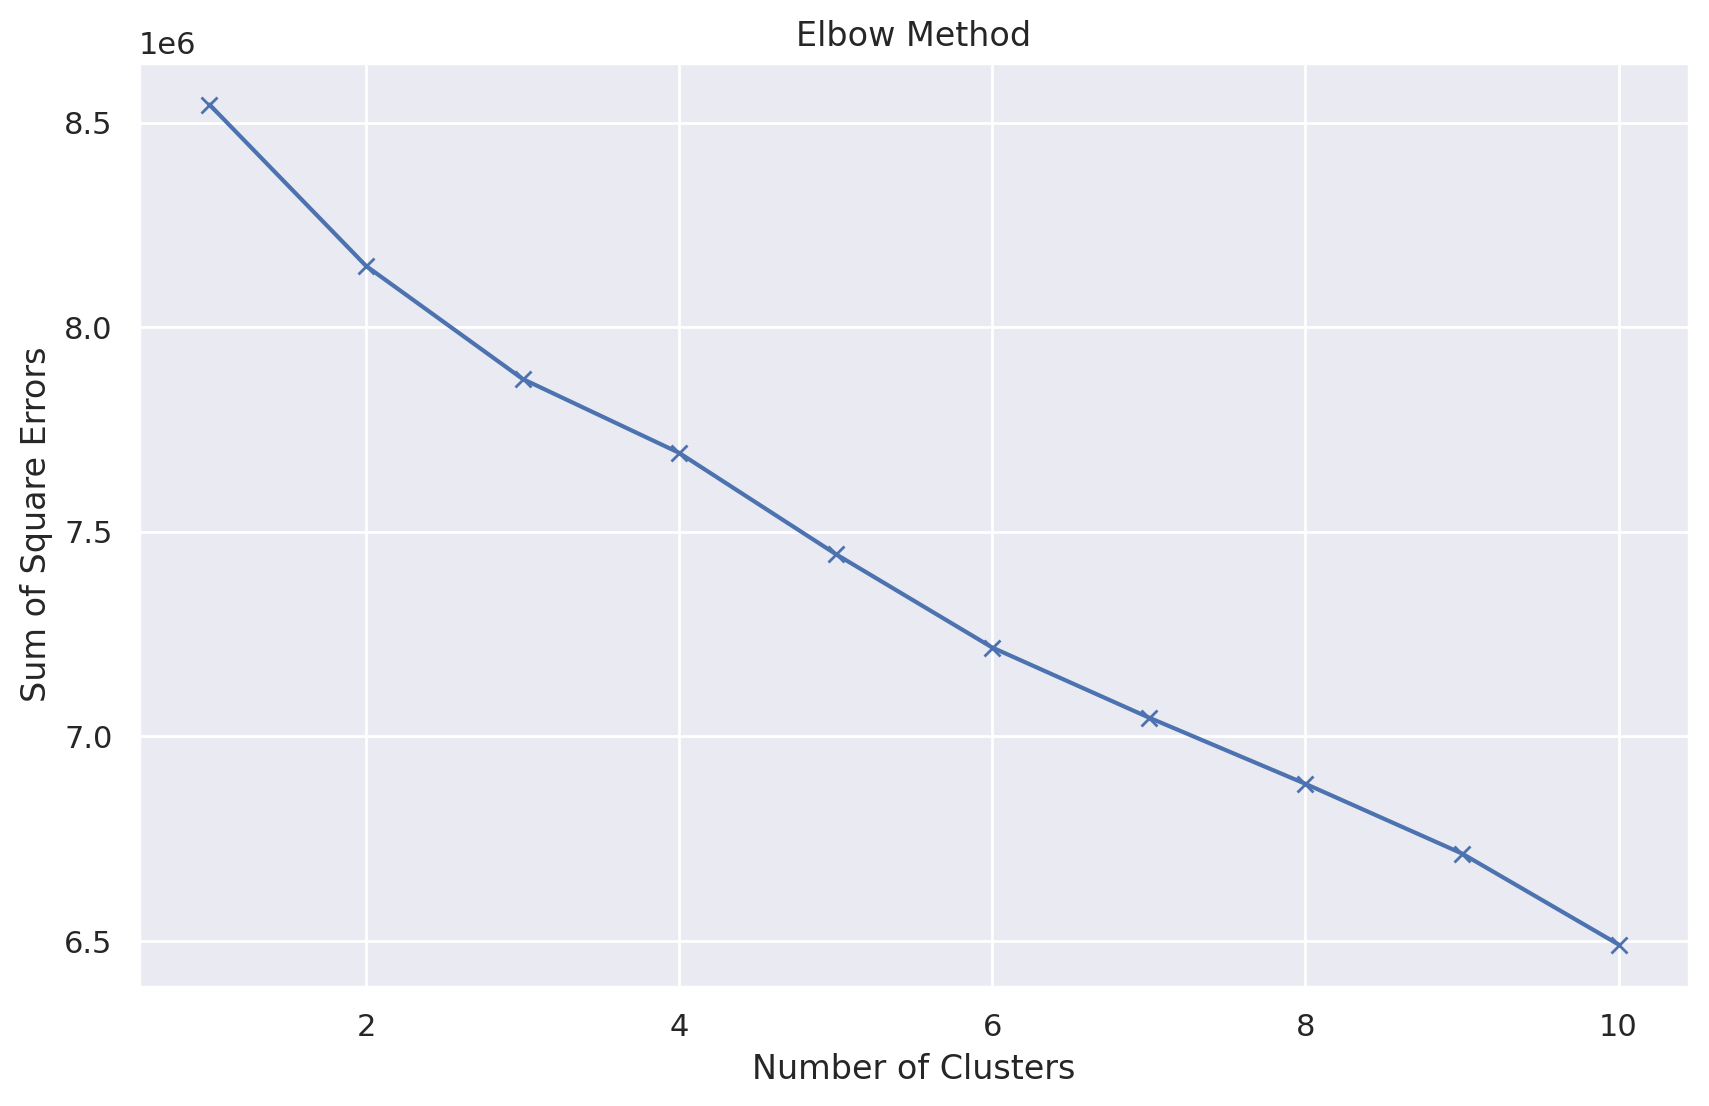

In [158]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbo method to find the optimal number of clusters
sse = []

k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Square Errors')
plt.title('Elbow Method')
plt.show()

In [159]:
optimal_cluster = 9

kmeans = KMeans(n_clusters=optimal_cluster, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [160]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Cluster
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,3
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,3
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1


In [161]:
np.unique(data['Cluster'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [162]:
# Analyze the distribution of the 'Class' in each cluster
cluster_analysis = data.groupby('Cluster')['Class'].value_counts(normalize=True).unstack()
print(cluster_analysis)

Class           0         1
Cluster                    
0        0.997903  0.002097
1        0.999372  0.000628
2        0.995688  0.004312
3        0.999355  0.000645
4        0.164609  0.835391
5        0.999641  0.000359
6        0.998576  0.001424
7        0.999900  0.000100
8        0.990420  0.009580


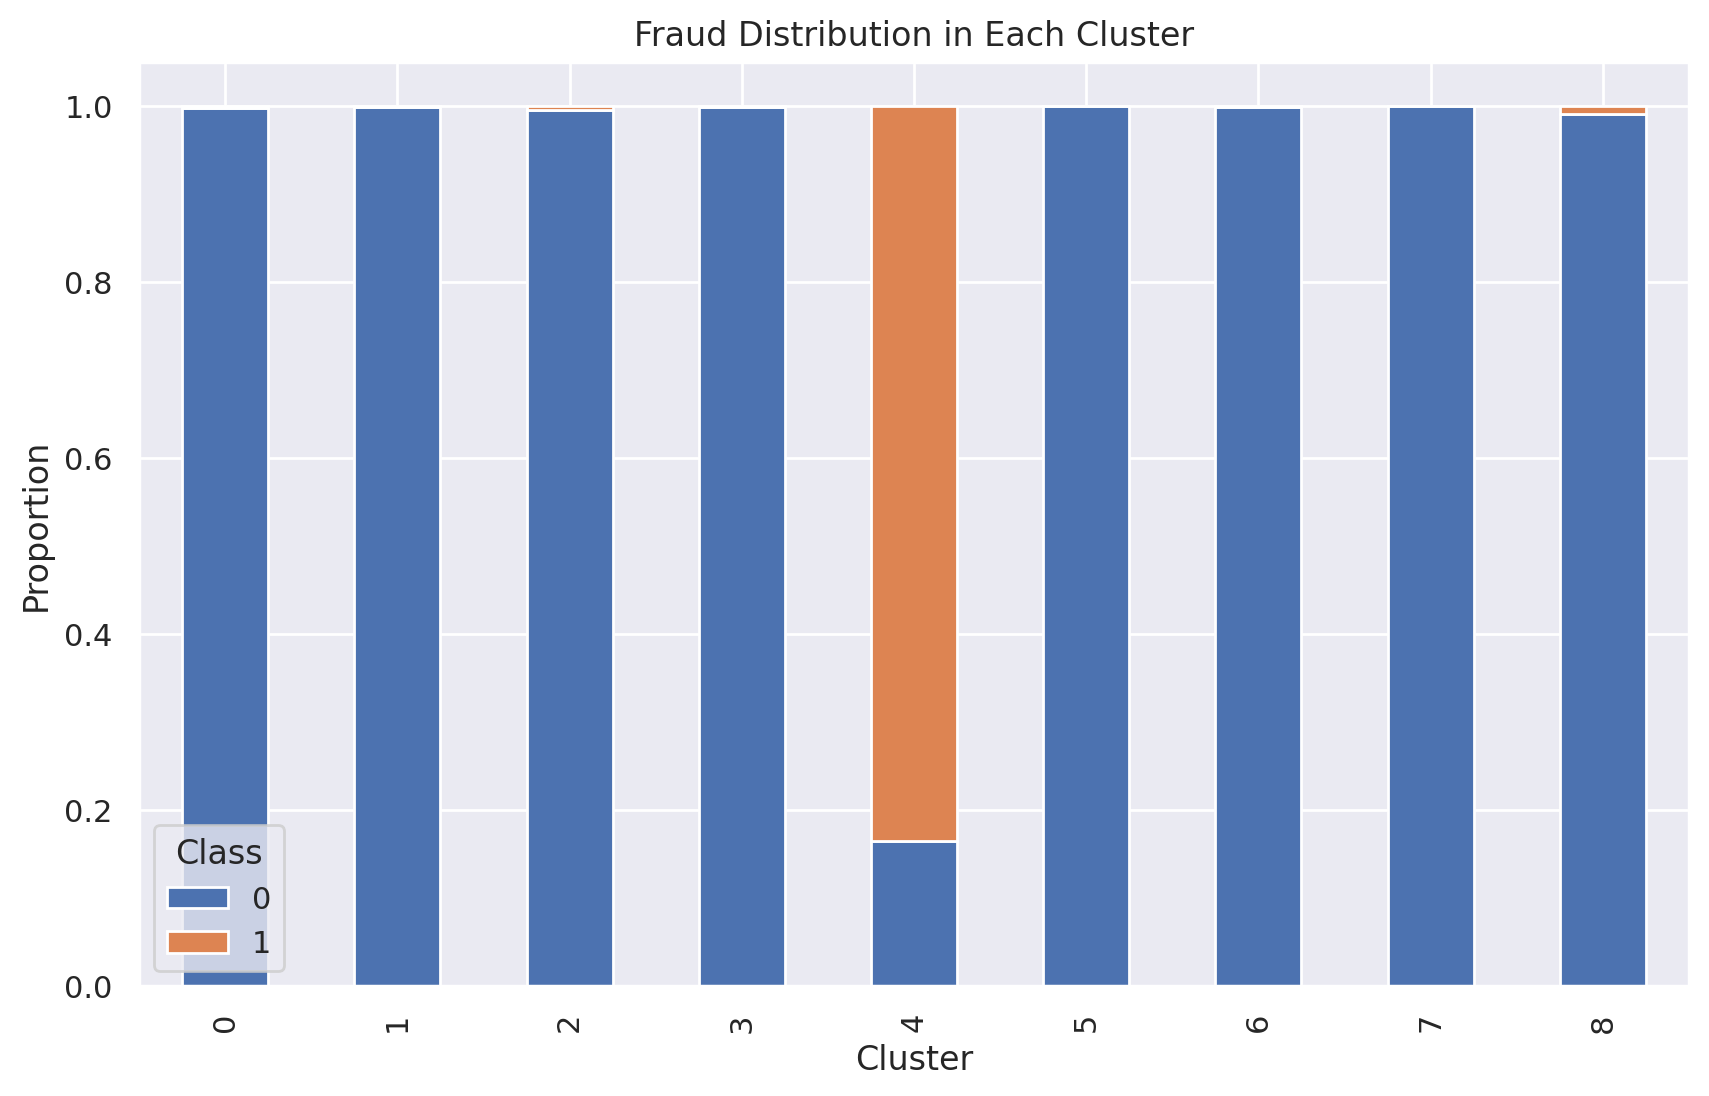

In [163]:
# Plot the distribution
cluster_analysis.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fraud Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

In [164]:
# Assuming 'data' is your DataFrame and 'Class' is the true label column

# Assign predictions based on cluster 3 being fraudulent
data['Predicted'] = np.where(data['Cluster'] == 4, 1, 0)

In [165]:
# True labels
true_labels = data['Class']

# Predicted labels
predicted_labels = data['Predicted']

In [166]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate classification report
class_report = classification_report(true_labels, predicted_labels)

# Display results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

kmeans_report = classification_report(true_labels, predicted_labels, output_dict=True)

Confusion Matrix:
[[284275     40]
 [   289    203]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.84      0.41      0.55       492

    accuracy                           1.00    284807
   macro avg       0.92      0.71      0.78    284807
weighted avg       1.00      1.00      1.00    284807




# LOF

In [167]:
data = dataframe.copy()

In [168]:
data.isnull().values.any()

False

In [169]:
# Take a sample of data
data_sample = data.sample(frac=0.1, random_state=1)
# data_sample = data

data_sample.shape

(28481, 31)

In [170]:
# Now we do the rest operation with this sample data to reduce processing
Fraud = data_sample[data_sample['Class']==1]
Valid = data_sample[data_sample['Class']==0]

# Find the ration of Outlier to Normal
outlier_fraction = len(Fraud)/float(len(Valid))

print(outlier_fraction)
print(len(Fraud))
print(len(Valid))

0.0017234102419808666
49
28432


In [171]:
# Create independent and dependent features

# create a list of column names
columns = data_sample.columns.to_list()

# Store the variable we are predicting
target = "Class"

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in [target]]

# Define a random state
# state = np.random.RandomState(42)

X = data_sample[columns]
Y = data_sample[target]

# print(state)
print(columns)
print(X.shape)
print(Y.shape)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
(28481, 30)
(28481,)


In [172]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)
X_scaled

array([[6.93970507e-01, 9.29498718e-01, 7.74794449e-01, ...,
        4.29322114e-01, 3.93704186e-01, 9.10638856e-05],
       [4.53398463e-01, 9.24765464e-01, 8.00659204e-01, ...,
        4.34267606e-01, 3.87232946e-01, 1.00729885e-04],
       [4.76791833e-01, 9.36343571e-01, 7.98175390e-01, ...,
        4.38733448e-01, 3.88555792e-01, 4.52775744e-05],
       ...,
       [1.83408186e-02, 9.36405459e-01, 7.97379056e-01, ...,
        4.35923246e-01, 3.91497770e-01, 9.97124111e-04],
       [5.71534401e-01, 8.60268518e-01, 8.35101773e-01, ...,
        4.66386007e-01, 3.98982561e-01, 4.68037848e-05],
       [3.83062089e-01, 9.72059154e-01, 7.87137641e-01, ...,
        4.25603213e-01, 3.85550098e-01, 9.83896954e-04]])

In [173]:
from sklearn.neighbors import LocalOutlierFactor

# Works just like K-nearest neighbor so n_neighbour parameter stands for no. of neighbors we have to search for a datapoint
# contamination parameter influences how aggressively the LOF algorithm identifies outliers
LOF_classifier = LocalOutlierFactor(n_neighbors=60, algorithm='auto', metric='minkowski',
                   p=2, metric_params=None, contamination=outlier_fraction)

In [174]:
y_pred = LOF_classifier.fit_predict(X_scaled)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [175]:
# Higher the lower the value(keep in my values are negative) higher the chance of it being outlier
score_prediction = LOF_classifier.negative_outlier_factor_
score_prediction

array([-1.41521537, -1.01177969, -1.03815066, ..., -1.20630712,
       -1.21780242, -1.10081692])

In [176]:
outlier_indices = np.where(y_pred == -1)[0]
print(len(outlier_indices))

50


In [177]:
#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
# !! CAREFUL RUN ONLY ONCE
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

Accuracy Score : 0.9977879990168884
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.36      0.37      0.36        49

    accuracy                           1.00     28481
   macro avg       0.68      0.68      0.68     28481
weighted avg       1.00      1.00      1.00     28481



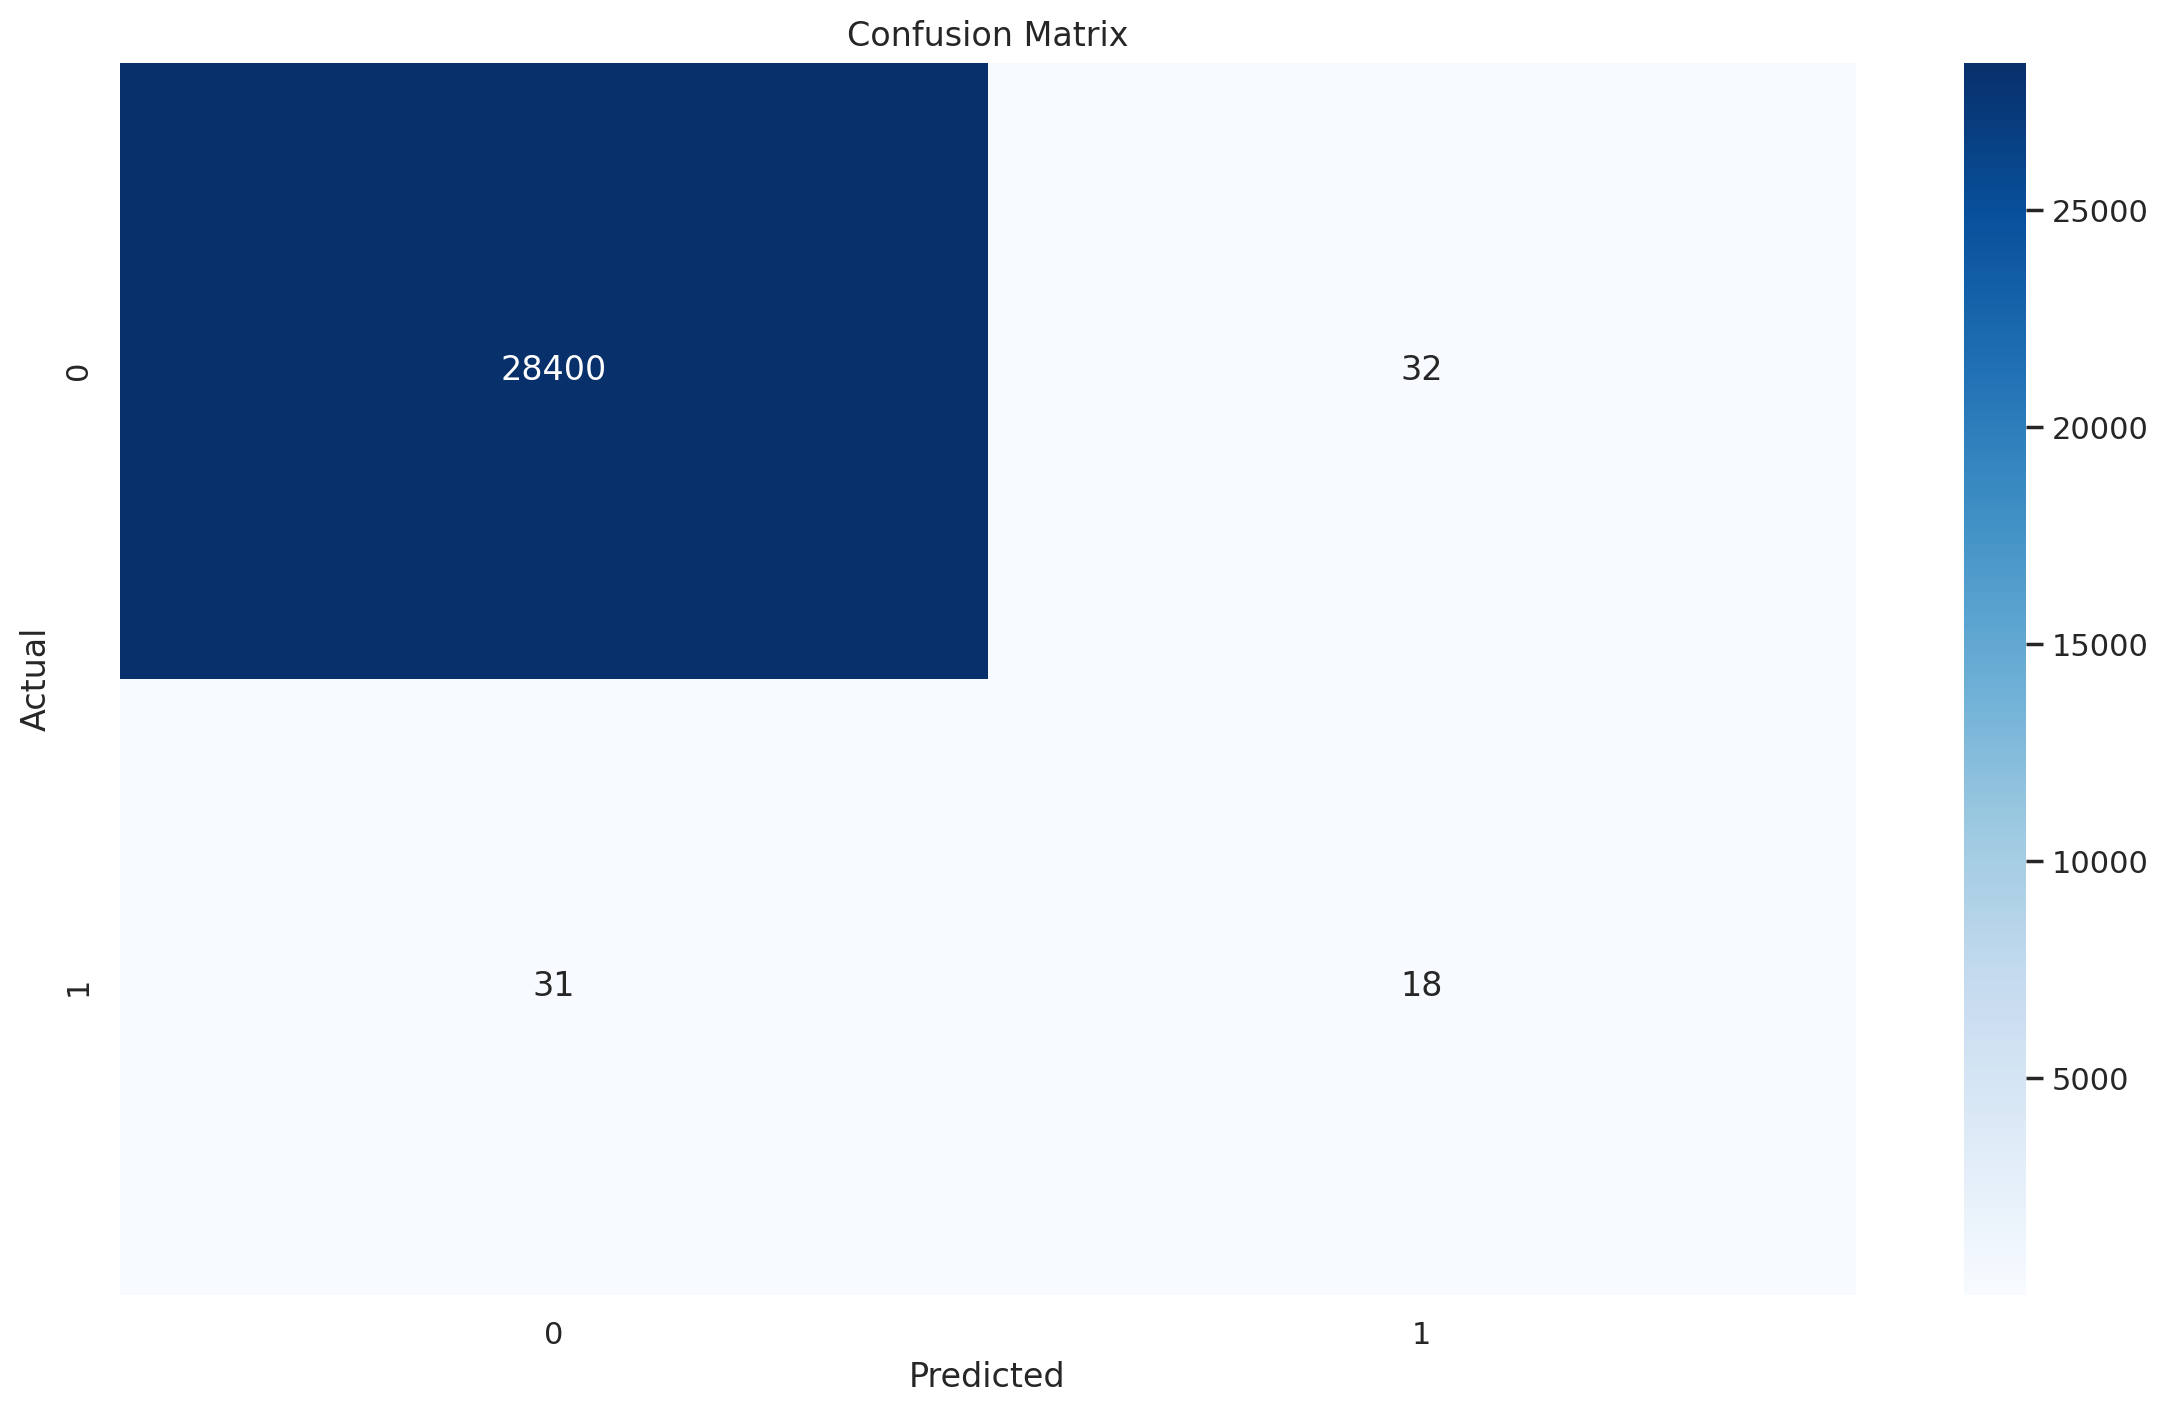

In [178]:
n_errors = (y_pred != Y).sum()

print("Accuracy Score :", accuracy_score(Y,y_pred))
print("Classification Report :")
print(classification_report(Y,y_pred))
lof_report = classification_report(Y,y_pred, output_dict=True)

plot_confusion_matrix(Y, y_pred)

## OneClassSVM

# SVM

In [179]:
df = dataframe.copy()

In [180]:
df_fraud = df[df['Class'] == 1] # Recovery of fraud data

In [181]:
nb_big_fraud = df_fraud[df_fraud['Amount'] > 1000].shape[0]
print(f'There are only {nb_big_fraud} frauds where the amount was bigger than 1000 over {df_fraud.shape[0]} frauds')

There are only 9 frauds where the amount was bigger than 1000 over 492 frauds


## Checking for unbalanced or balanced data

In [182]:
print(f'There are only {len(df_fraud)}  frauds in the original dataset, even though there are {len(df[df.Class==0])} normal in the dataset.')

There are only 492  frauds in the original dataset, even though there are 284315 normal in the dataset.


In [183]:
df_corr = df.corr()

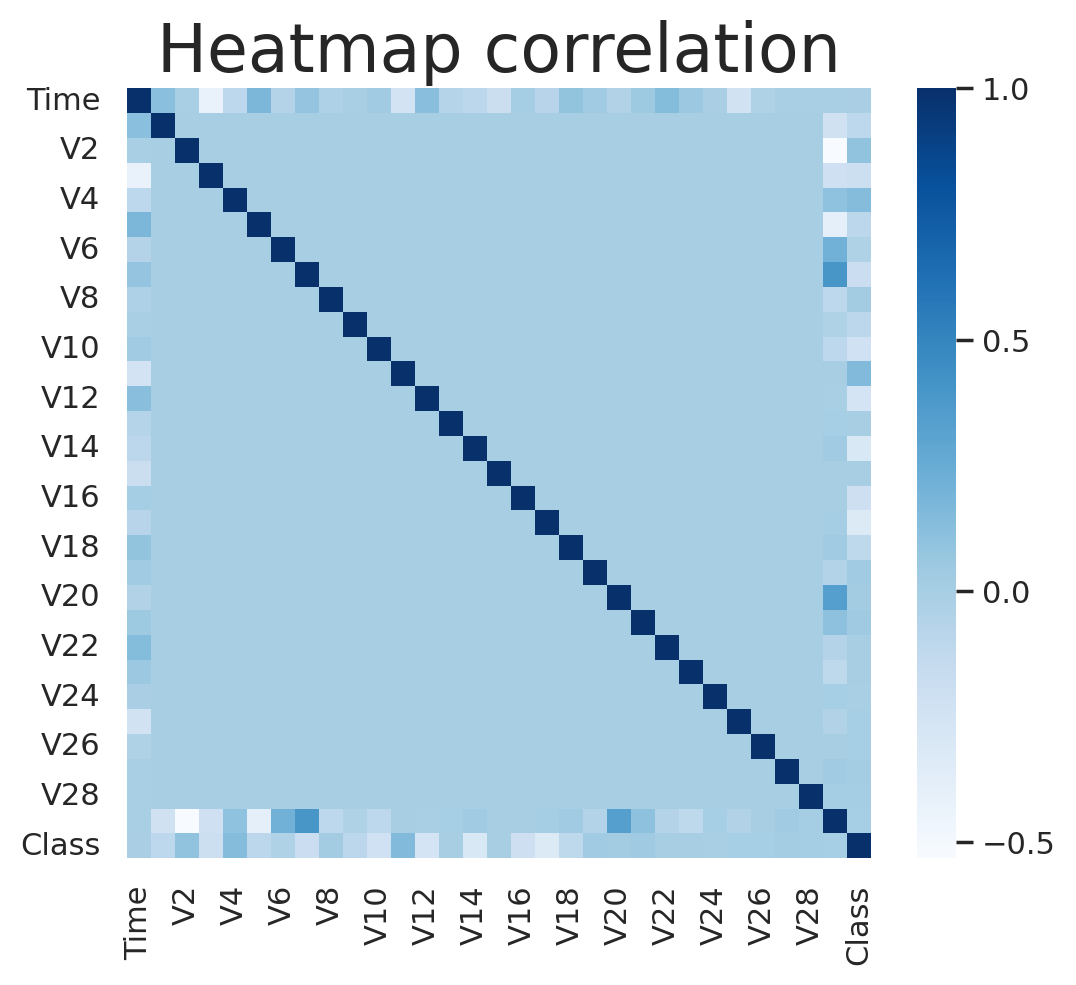

In [184]:
plt.figure(figsize=(6,5))
sns.heatmap(df_corr, cmap='Blues')
sns.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

From the above heat map we can easily conclude that there are very few correlated features in it . This waves or points towards the presence of a PCA being applied on this .

In [185]:
class_names=np.array(['0','1']) # Binary label

In [186]:
# Assuming 'Class' is the label column with 1 for fraud and 0 for normal transactions
X = data.drop(columns=['Class'])
y = data['Class']

In [187]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train and test split

In [188]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [189]:
print(f'There are {X_train.shape[0]} samples in the training set and {X_test.shape[0]} samples in the test set.')

There are 199364 samples in the training set and 85443 samples in the test set.


In [190]:
len(y_test[y_test == 1])

136

In [191]:
# Train One-Class SVM on normal transactions only

X_train_normal = X_train[y_train == 0]

In [192]:
from sklearn.svm import OneClassSVM

# Initialise OneClassSVM class
ocsvm = OneClassSVM(kernel='rbf', nu=0.01, gamma='auto')

In [193]:
# Fiting the data
ocsvm.fit(X_train_normal)

OneClassSVM(gamma='auto', nu=0.01)

In [194]:
# Predict on the test set
y_pred = ocsvm.predict(X_scaled)

In [195]:
# Map predictions to 0 for normal and 1 for anomaly to match the original labels
y_pred = [1 if x == -1 else 0 for x in y_pred]

In [196]:
anomalies_count = sum(y_pred)
print("Number of anomalies predicted:", anomalies_count)

Number of anomalies predicted: 3503


In [197]:
# Generate the confusion matrix
cm = confusion_matrix(y, y_pred)

In [198]:
print("Classification Report: ")
print(classification_report(y, y_pred))

svm_report = classification_report(y, y_pred, output_dict=True)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.12      0.83      0.20       492

    accuracy                           0.99    284807
   macro avg       0.56      0.91      0.60    284807
weighted avg       1.00      0.99      0.99    284807



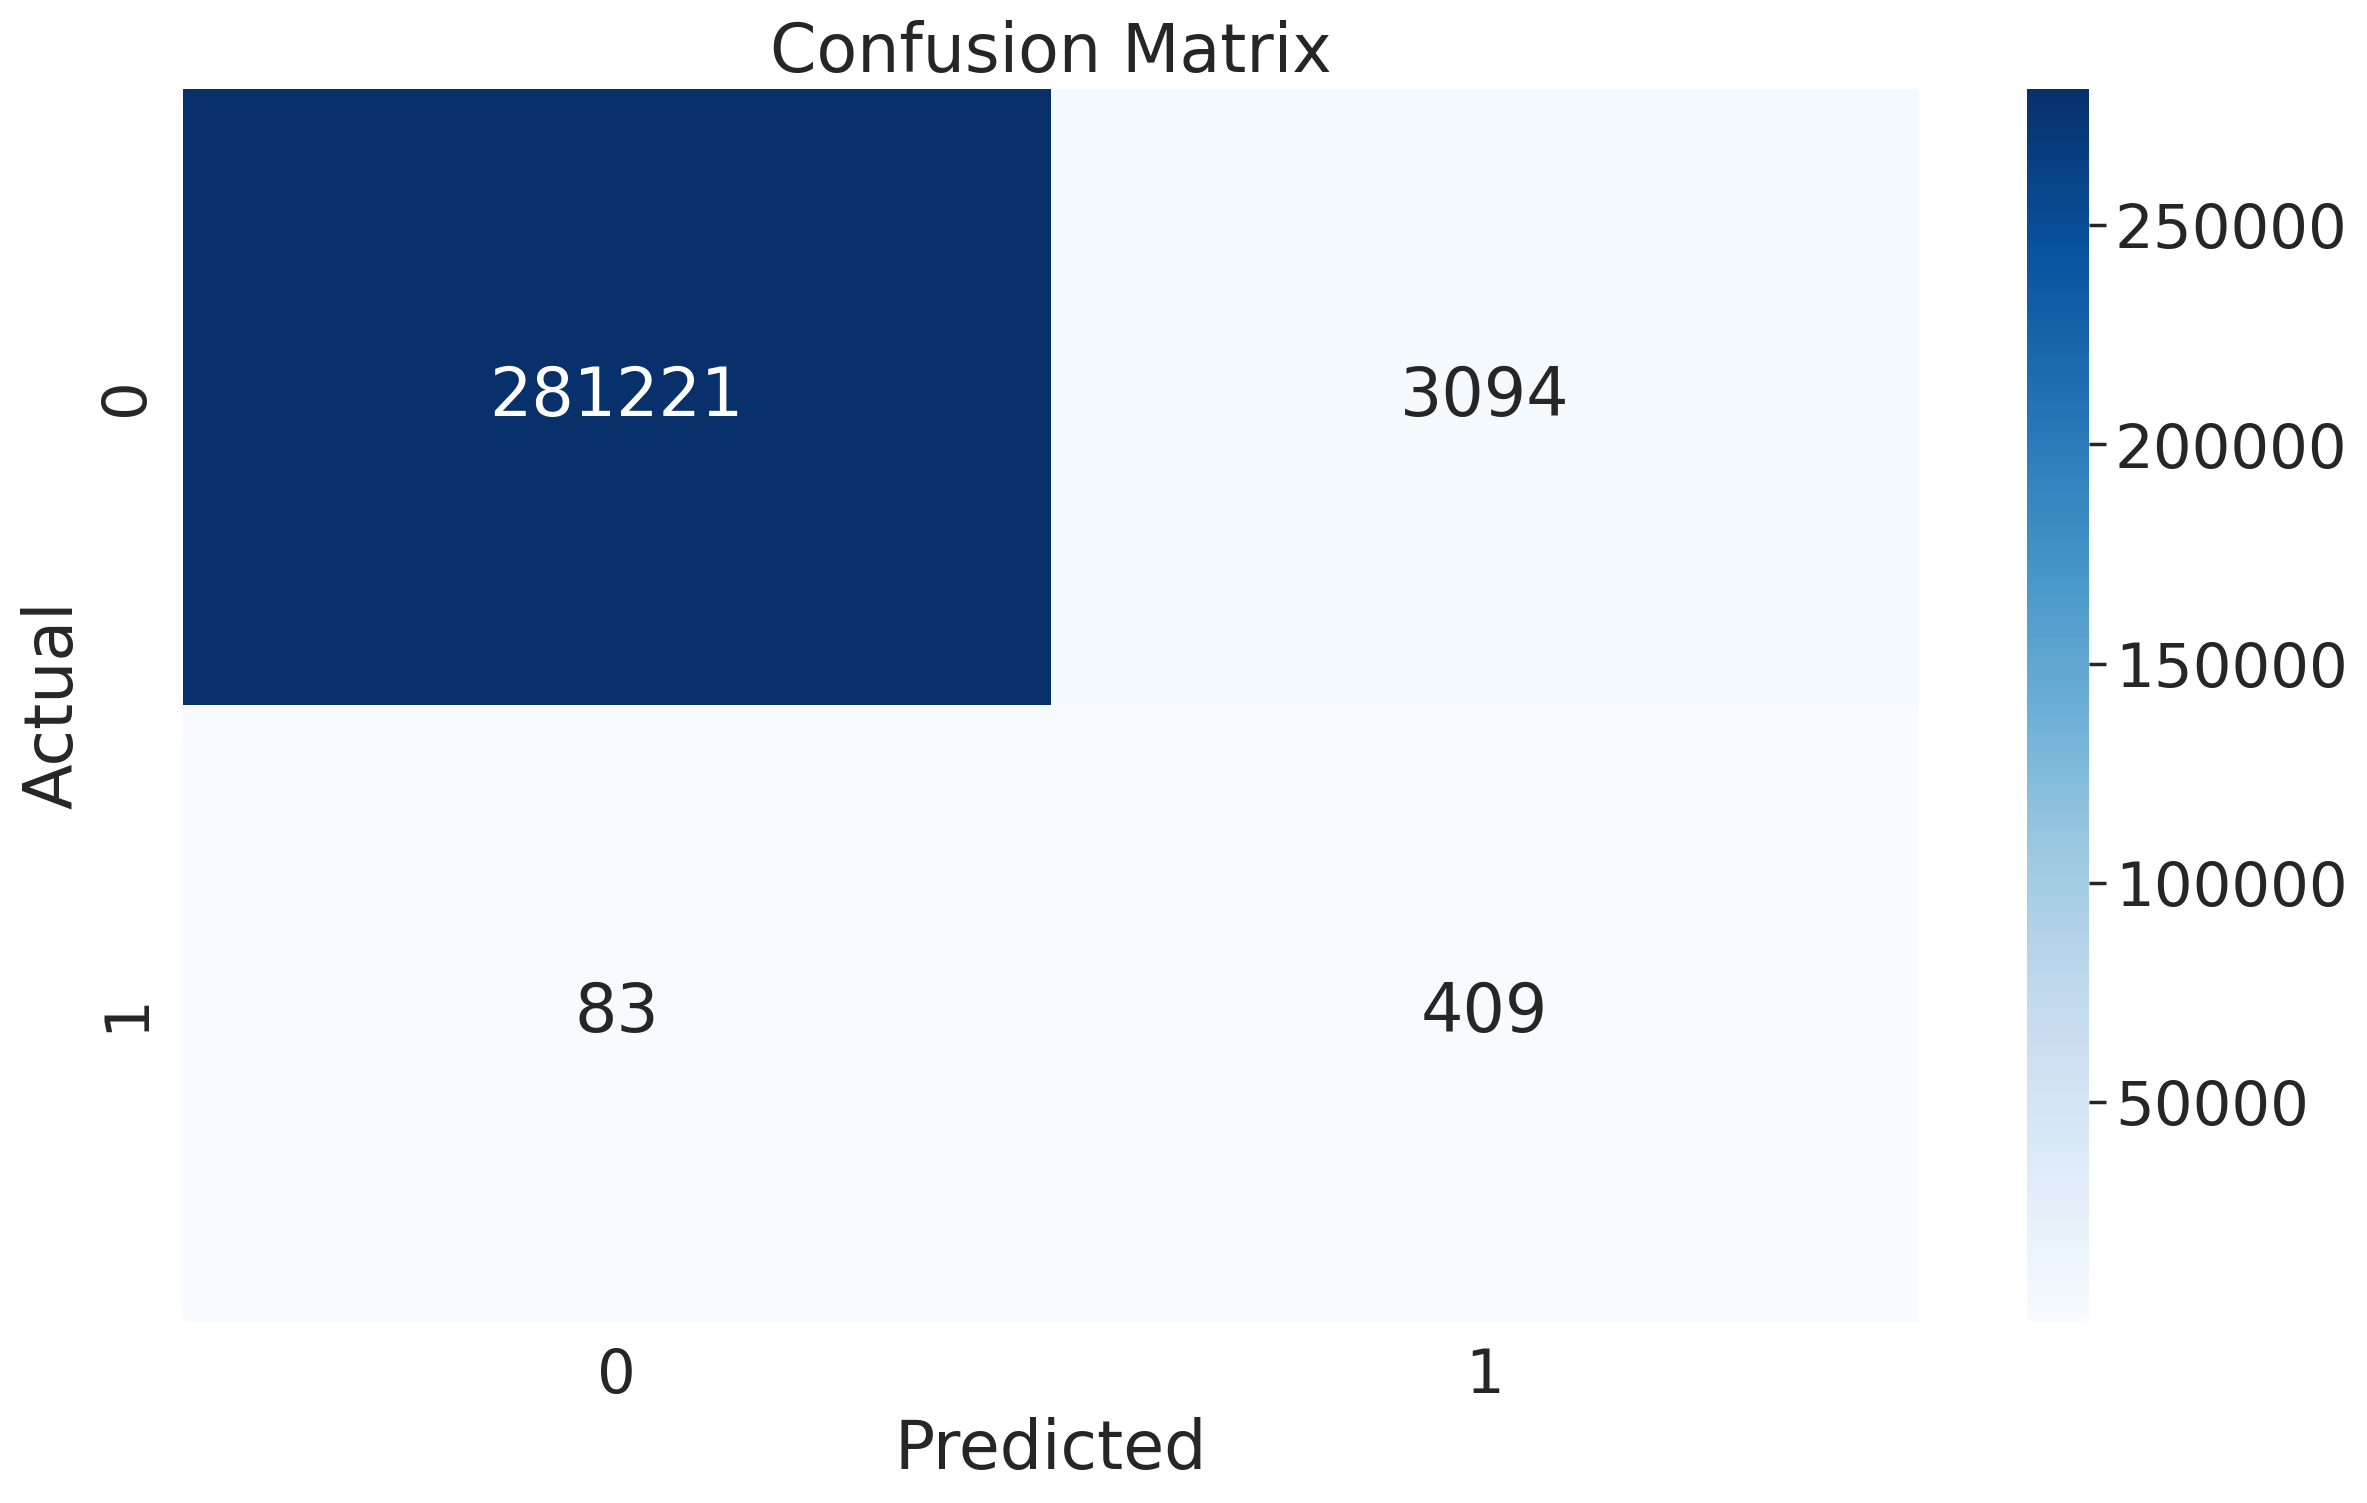

In [200]:
plot_confusion_matrix(y, y_pred)

# PCA

In [201]:
data = dataframe.copy()

In [202]:
# Separate the dataset into normal and anomaly counts
s = data["Class"].value_counts()
print("Number of anomalies:", s.iloc[1])
print("Number of normal instances:", s.iloc[0])

Number of anomalies: 492
Number of normal instances: 284315


In [203]:
# Feature data
X = data.drop(columns=["Class", "Time"])

In [204]:
# Scale all feature vectors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [205]:
# Apply PCA for dimensionality reduction (to 28 dimensions)
pca_28 = PCA(n_components=28)
X_pca_28 = pca_28.fit_transform(X_scaled)

In [206]:
# Reconstructing the dataset from the reduced dimensions
X_reconstructed = pca_28.inverse_transform(X_pca_28)

In [207]:
# Compute reconstruction error
reconstruction_error = np.sum(np.square(X_scaled - X_reconstructed), axis=1)

In [208]:
# Determine the threshold for anomalies (99.8 percentile)
threshold = np.percentile(reconstruction_error, 99.8)

In [209]:
# Identifying anomalies based on reconstruction error
anomalies_indices = np.where(reconstruction_error > threshold)[0]
anomalies = data.iloc[anomalies_indices]

In [210]:
# Generate predictions
y_pred = np.zeros(y.shape)
y_pred[anomalies_indices] = 1


In [211]:
# Classification report
print("Classification Report:")
print(classification_report(y, y_pred))

pca_report = classification_report(y, y_pred, output_dict=True)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.01      0.01      0.01       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



# MCD

In [212]:
df = dataframe.copy()

In [213]:
# Sample the dataframe
df = df.sample(frac=0.1, random_state=42)

In [214]:
class_count = df['Class'].value_counts()
frequency = class_count[1]/class_count[0]
frequency

0.001617724635132759

In [215]:
X = df.drop('Class', axis=1)
y = df['Class']

In [216]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [217]:
X_scaled.shape

(28481, 30)

In [218]:
from pyod.models.mcd import MCD

mcd_detector = MCD(contamination=frequency, support_fraction=1, random_state=42)

In [219]:
# Fit the model
mcd_detector.fit(X_scaled)

MCD(assume_centered=False, contamination=0.001617724635132759,
  random_state=42, store_precision=True, support_fraction=1)

In [220]:
# Get the prediction
pred = mcd_detector.predict(X_scaled)

In [221]:
# Get the decision scores
scores = mcd_detector.decision_scores_

In [222]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score, adjusted_rand_score, mutual_info_score, precision_recall_curve, auc
# Calculate ROC AUC
roc_auc = roc_auc_score(y, scores)
f1 = f1_score(y, pred)
ari = adjusted_rand_score(y, pred)
mi_score = mutual_info_score(y, pred)

In [223]:
print("ROC AUC Score:", roc_auc)
print("F1 Score:", f1)
print("Adjusted Rand Index:", ari)
print("Mutual Information Score:", mi_score)

ROC AUC Score: 0.9834901873838885
F1 Score: 0.7741935483870968
Adjusted Rand Index: 0.7732518625364866
Mutual Information Score: 0.007955049868882524


In [224]:
print(classification_report(y, pred))
print(confusion_matrix(y, pred))
print(f"Recall score: {recall_score(y, pred)}")

mcd_report = classification_report(y, pred, output_dict=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.77      0.78      0.77        46

    accuracy                           1.00     28481
   macro avg       0.88      0.89      0.89     28481
weighted avg       1.00      1.00      1.00     28481

[[28424    11]
 [   10    36]]
Recall score: 0.782608695652174


# Conclusion

In [225]:
# Sample reports dictionary structure
reports = {
    'Isolation Forest': if_report,
    'K-Means': kmeans_report,
    'PCA': pca_report,
    'DBSCAN': dbscan_report,
    'ANN': ann_report,
    'GMM': gmm_report,
    'HBOS': hbos_report,
    'LOF': lof_report,
    'SVM': svm_report,
    'MCD': mcd_report,
    'CBLOF': cblof_report
}

<ipython-input-226-670f8e98ab88>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_algorithms, y=f1_scores_normal_list, ax=axes[0], palette="Blues_d")
<ipython-input-226-670f8e98ab88>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_algorithms, y=f1_scores_anomaly_list, ax=axes[1], palette="Reds_d")


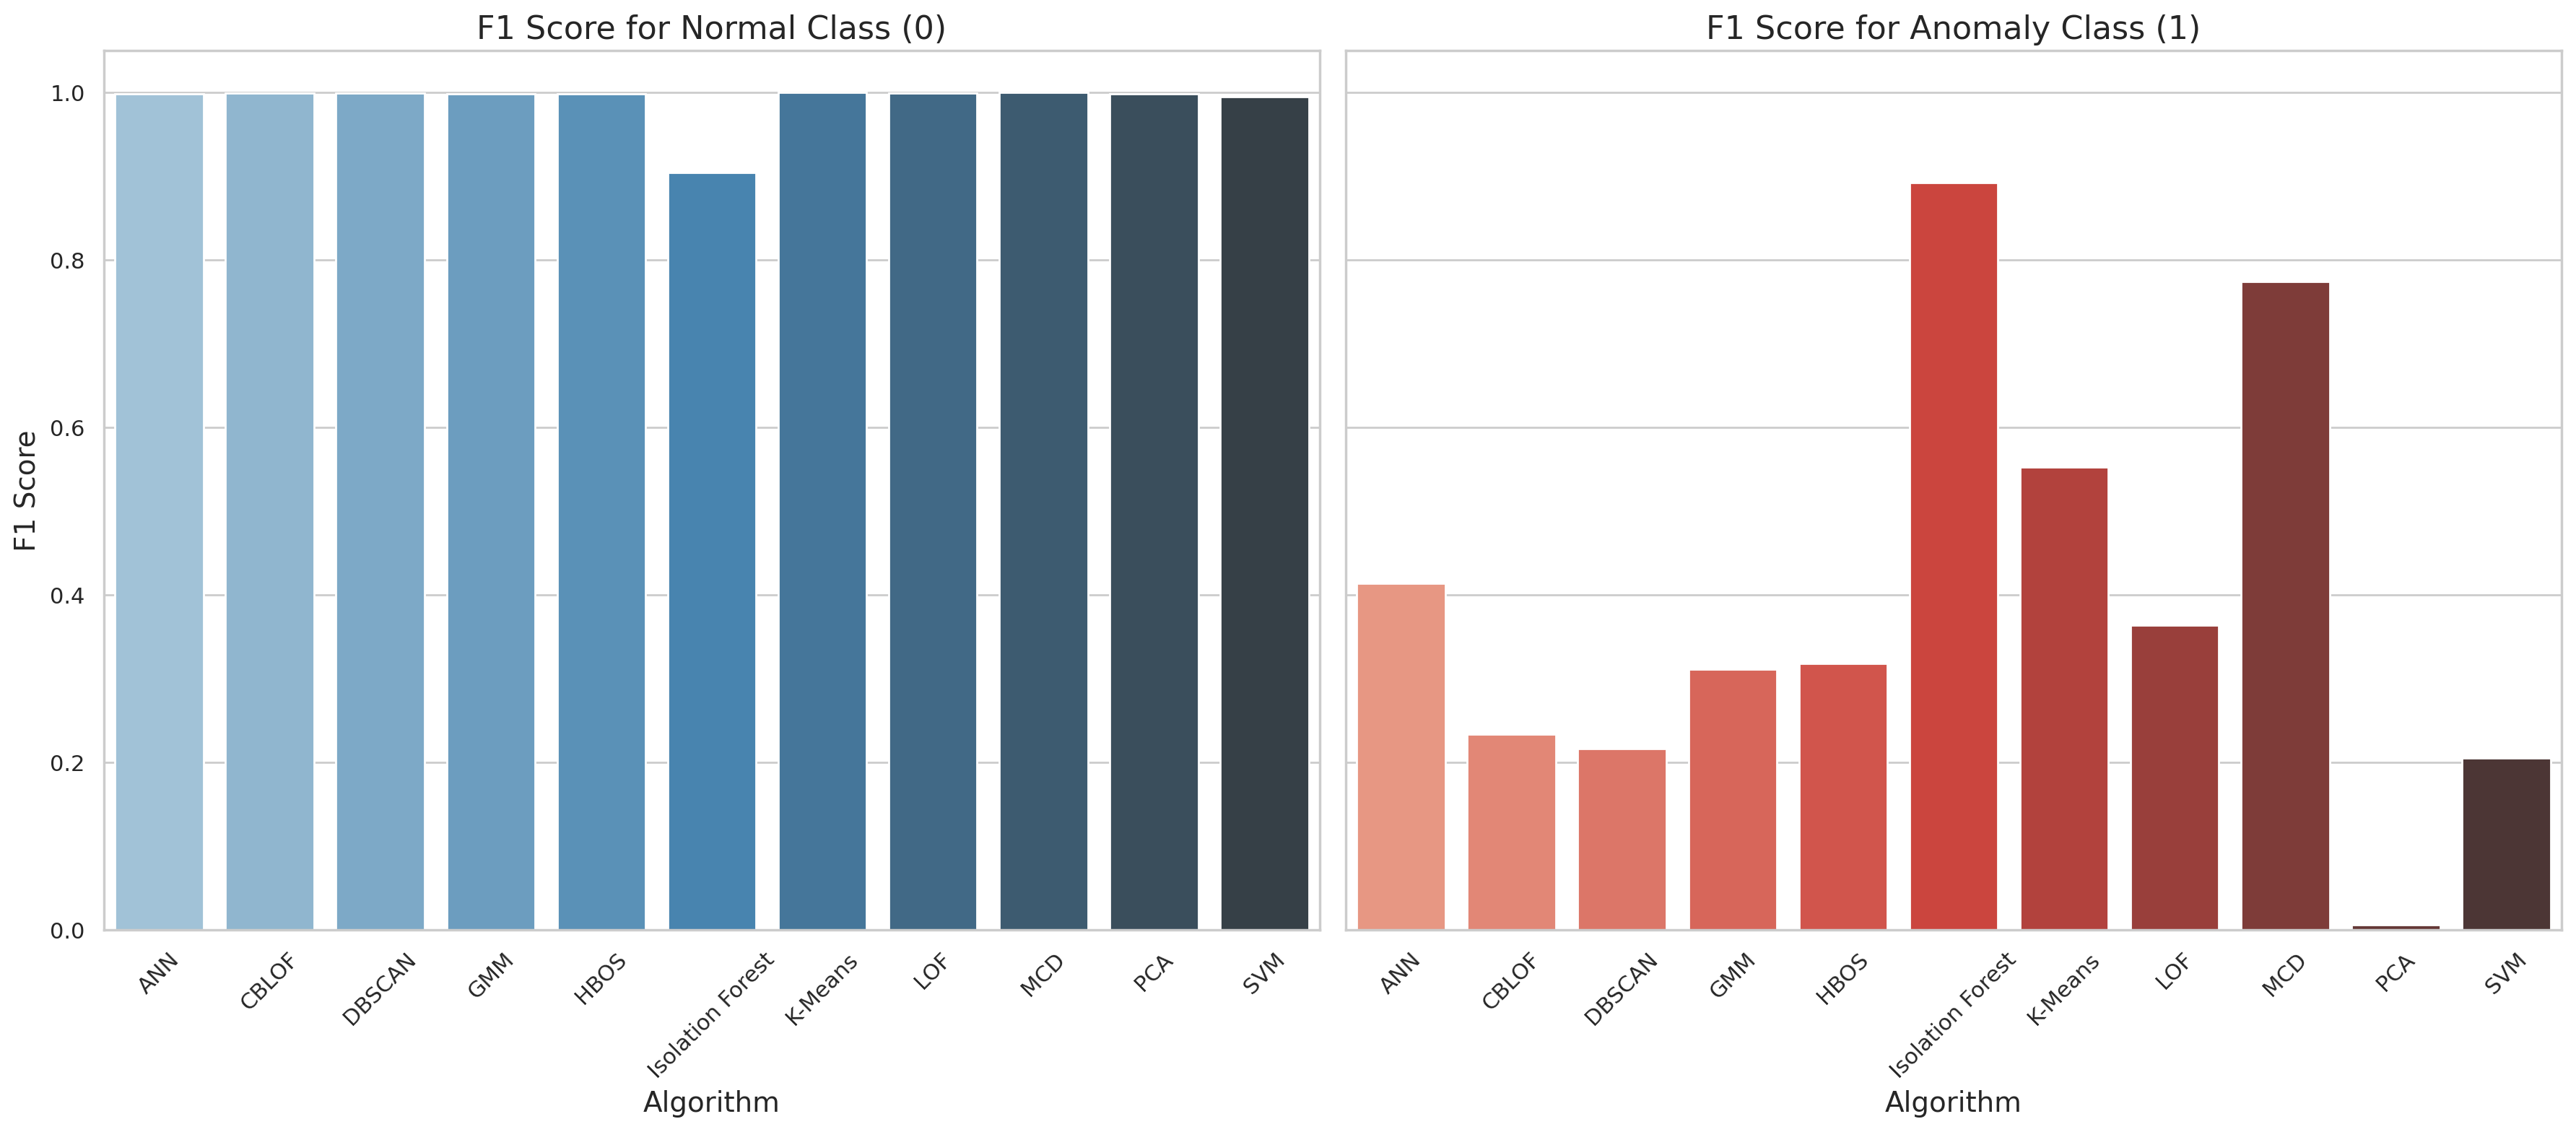

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract F1 scores for each class from the reports
f1_scores_normal = {}
f1_scores_anomaly = {}

for name, report in reports.items():
    f1_scores_normal[name] = report['0']['f1-score']
    f1_scores_anomaly[name] = report['1']['f1-score']

# Convert the extracted scores to lists of tuples sorted by algorithm name
sorted_algorithms = sorted(f1_scores_normal.keys())
f1_scores_normal_list = [f1_scores_normal[alg] for alg in sorted_algorithms]
f1_scores_anomaly_list = [f1_scores_anomaly[alg] for alg in sorted_algorithms]

# Plotting
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Bar plot for Normal Class (0)
sns.barplot(x=sorted_algorithms, y=f1_scores_normal_list, ax=axes[0], palette="Blues_d")
axes[0].set_title('F1 Score for Normal Class (0)', fontsize=16)
axes[0].set_xlabel('Algorithm', fontsize=14)
axes[0].set_ylabel('F1 Score', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Bar plot for Anomaly Class (1)
sns.barplot(x=sorted_algorithms, y=f1_scores_anomaly_list, ax=axes[1], palette="Reds_d")
axes[1].set_title('F1 Score for Anomaly Class (1)', fontsize=16)
axes[1].set_xlabel('Algorithm', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

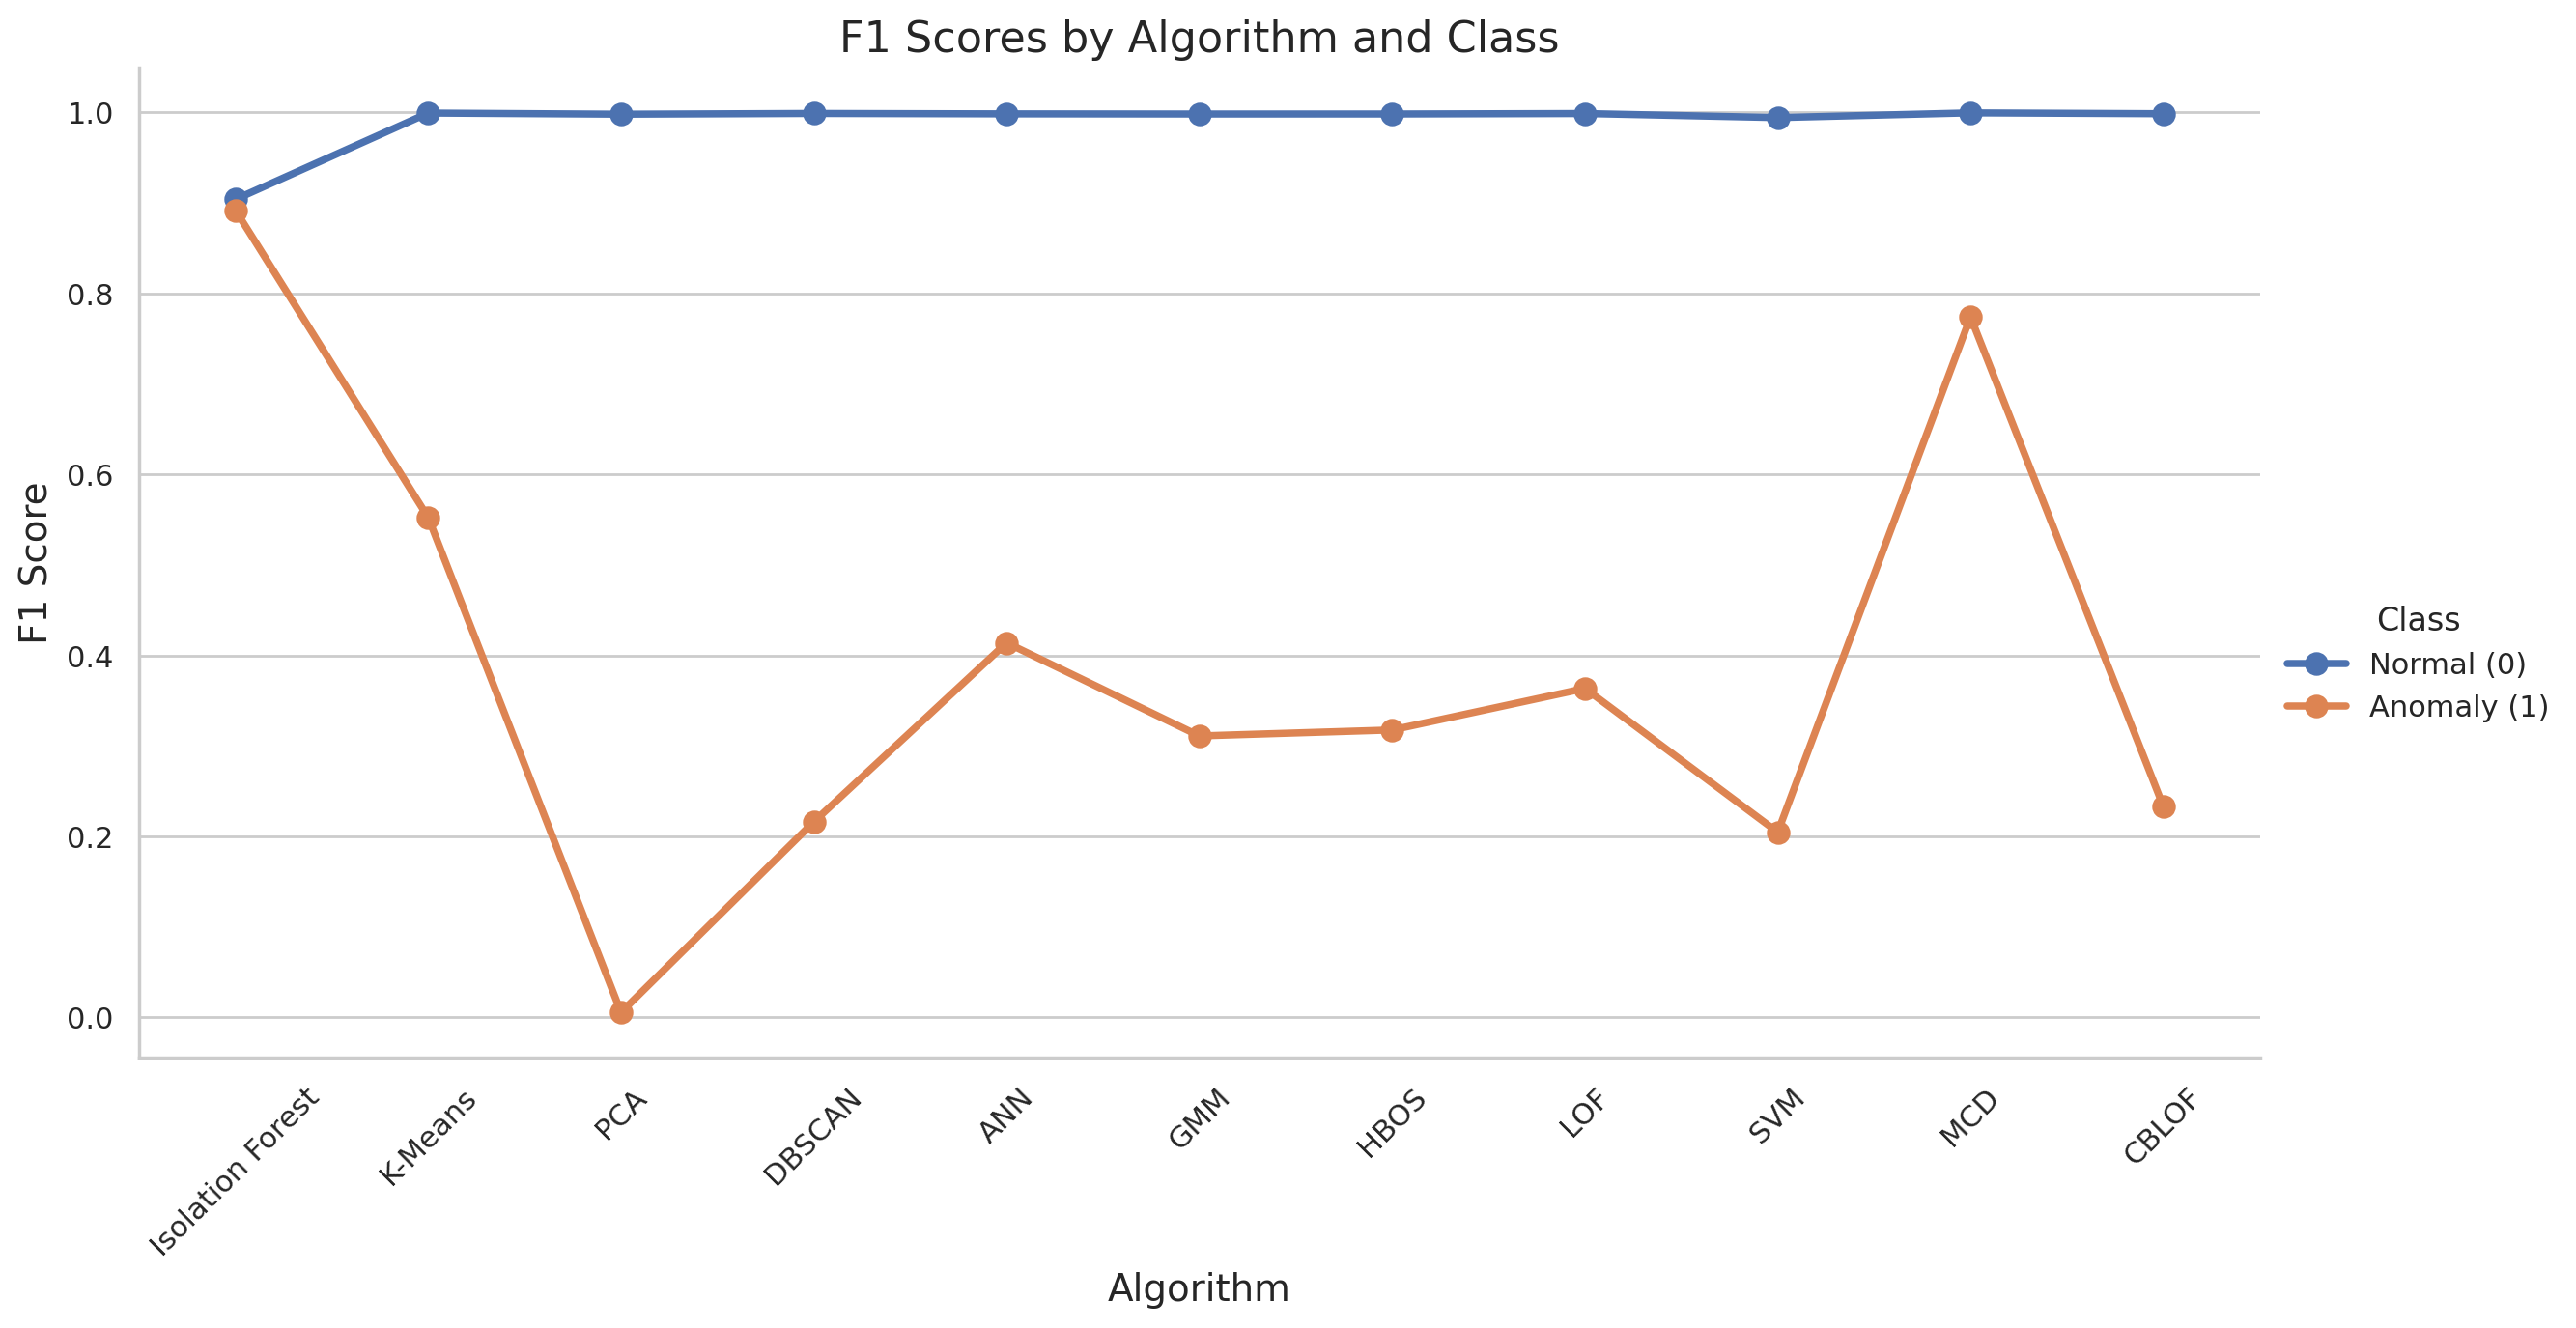

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract F1 scores for each class from the reports
data = {'Algorithm': [], 'Class': [], 'F1 Score': []}
for name, report in reports.items():
    data['Algorithm'].append(name)
    data['Class'].append('Normal (0)')
    data['F1 Score'].append(report['0']['f1-score'])
    data['Algorithm'].append(name)
    data['Class'].append('Anomaly (1)')
    data['F1 Score'].append(report['1']['f1-score'])

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 8))
sns.catplot(data=df, x='Algorithm', y='F1 Score', hue='Class', kind='point', height=6, aspect=2)
plt.xticks(rotation=45)
plt.title('F1 Scores by Algorithm and Class', fontsize=16)
plt.xlabel('Algorithm', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.show()
